In [1]:
# Ocean Heat Budget Analyses in the Antarctica continental shelf (WAOM)

# Fabio B Dias - 15 August 2023
# Description:
#     this script get the heat transport across CF calculate for individual experiments:
# WAOM10: WAOM10extend_shflim_S_0.25Q_Cross-CF-Transport.ipynb
# WAOM4: WAOM4extend_shflim_S_0.25Q_Cross-CF-Transport.py
# WAOM4-NOTIDE: WAOM4extend_shflim_S_0.25Q_notides_Cross-CF-Transport.py
# WAOM2:
# and plot vertically-integrated analyses:
# 1) annual average



In [2]:
# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as  np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps
import cmocean

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


import gsw

import pyresample

from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37267/status,
Dashboard: /proxy/37267/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34187,Workers: 7
Dashboard: /proxy/37267/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:46333,Total threads: 4
Dashboard: /proxy/39891/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:34177,


In [4]:
tmp_files_dir = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'

In [5]:
# determine constants:
rho0 = 1025 # kg. m-3
Cp = 3989.245 # J.kg-1.degC-1
Tf = -1.95 # degC


In [6]:
%%time

# load waom4 3D temp field to plot some maps

ds = xr.open_mfdataset(paths='/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_01-20yr/ocean_avg_0010.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp3d_4km= ds.variables["temp"]
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho3d_4km = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
del Zo_rho
ds.close()

# read grid file for lon/lat coordinates
dg = xr.open_dataset("/g/data3/hh5/tmp/access-om/fbd581/ROMS/waom4_frc/waom4extend_grd.nc")
lat_rho_4km= dg.variables["lat_rho"]
lon_rho_4km = dg.variables["lon_rho"]
pm_4km = dg.variables["pm"]
pn_4km = dg.variables["pn"]
zice_4km = dg.variables["zice"]
h_4km = dg.variables["h"]
dg.close()
print('Print lon/lat_rho shapes',lon_rho_4km.shape, lat_rho_4km.shape)
print('Print lon/lat_rho shapes',lon_rho_4km[0:-1,0:-1].shape, lat_rho_4km[0:-1,0:-1].shape)

# ----------------------------------------------------------------------------------------------------------------
# load calving front contour for plots as well:
tmp_files_dir = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
expt = 'WAOM4'
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_CalvingFront')
lon_along_4km_CF = ds.variables["one"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_CalvingFront')
lat_along_4km_CF = ds.variables["two"]
ds.close()

temp3d_4km.load()
z_rho3d_4km.load()

Print lon/lat_rho shapes (1400, 1575) (1400, 1575)
Print lon/lat_rho shapes (1399, 1574) (1399, 1574)
CPU times: user 10.5 s, sys: 13.5 s, total: 24 s
Wall time: 1min 1s


<xarray.DataArray (ocean_time: 12, eta_rho: 1400, xi_rho: 1575, s_rho: 31)> Size: 7GB
array([[[[-4.24380735e+03, -4.22589128e+03, -4.18901382e+03, ...,
          -2.87512373e+01, -1.49424020e+01, -4.30370142e+00],
         [-4.24398793e+03, -4.22607137e+03, -4.18919258e+03, ...,
          -2.87517126e+01, -1.49425814e+01, -4.30372722e+00],
         [-4.27045608e+03, -4.25246917e+03, -4.21539530e+03, ...,
          -2.88256797e+01, -1.49732028e+01, -4.31185378e+00],
         ...,
         [-3.16230931e+03, -3.14730263e+03, -3.11842774e+03, ...,
          -2.61661710e+01, -1.41634905e+01, -4.47942162e+00],
         [-3.24143069e+03, -3.22620852e+03, -3.19674606e+03, ...,
          -2.63876161e+01, -1.42500385e+01, -4.49327846e+00],
         [-3.30510133e+03, -3.28970615e+03, -3.25977121e+03, ...,
          -2.65649130e+01, -1.43191933e+01, -4.50435974e+00]],

        [[-4.31585225e+03, -4.29774467e+03, -4.26033618e+03, ...,
          -2.89406212e+01, -1.50138302e+01, -4.31393948e+00],
         [-3.93856221e+03, -3.92145999e+03, -3.88683453e+03, ...,
          -2.79422974e+01, -1.46357942e+01, -4.25898247e+00],
         [-4.04688335e+03, -4.02949185e+03, -3.99406685e+03, ...,
          -2.82349761e+01, -1.47497213e+01, -4.27946704e+00],
...
         [-4.79253176e+03, -4.77316596e+03, -4.73225662e+03, ...,
          -3.11971896e+01, -1.64979348e+01, -5.40051886e+00],
         [-4.91642199e+03, -4.89672920e+03, -4.85490864e+03, ...,
          -3.15133334e+01, -1.66136505e+01, -5.41348549e+00],
         [-4.99916509e+03, -4.97925417e+03, -4.93682524e+03, ...,
          -3.17261085e+01, -1.66928124e+01, -5.42427595e+00]],

        [[-4.55005276e+03, -4.53132707e+03, -4.49219986e+03, ...,
          -3.02911260e+01, -1.59846216e+01, -5.08902629e+00],
         [-4.51929803e+03, -4.50065381e+03, -4.46175304e+03, ...,
          -3.02110210e+01, -1.59545794e+01, -5.08480736e+00],
         [-4.22767876e+03, -4.20980876e+03, -4.17305671e+03, ...,
          -2.94529053e+01, -1.56729471e+01, -5.04985683e+00],
         ...,
         [-4.81272396e+03, -4.79330484e+03, -4.75224696e+03, ...,
          -3.12493429e+01, -1.65173926e+01, -5.40320000e+00],
         [-4.92887486e+03, -4.90914923e+03, -4.86723709e+03, ...,
          -3.15453880e+01, -1.66255843e+01, -5.41511703e+00],
         [-5.02170386e+03, -5.00173354e+03, -4.95913892e+03, ...,
          -3.17839854e+01, -1.67143258e+01, -5.42719812e+00]]]])
Coordinates:
    Vtransform  int32 4B 2
    hc          float64 8B 250.0
    h           (eta_rho, xi_rho) float64 18MB 4.249e+03 4.25e+03 ... 5.028e+03
    x_rho       (eta_rho, xi_rho) float64 18MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    y_rho       (eta_rho, xi_rho) float64 18MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
  * ocean_time  (ocean_time) datetime64[ns] 96B 2016-01-14T05:00:00 ... 2016-...
  * s_rho       (s_rho) float64 248B -0.9839 -0.9516 ... -0.04839 -0.01613
    Cs_r        (s_rho) float64 248B -0.9995 -0.997 ... -0.0008464 -9.329e-05
Dimensions without coordinates: eta_rho, xi_rho

In [7]:
# load ice draft to create masks
expt = 'WAOM10'

# ds = xr.open_dataset(tmp_files_dir + expt + '_Tf_heat_trans_CF_daily')
# Tf_heat_transport_10km = ds.variables["__xarray_dataarray_variable__"]
# ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_heat_trans_CF_daily')
heat_transport_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_vol_trans_CF_daily')
vol_transport_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_temp_CF_daily')
temp_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_salt_CF_daily')
salt_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_z_rho_CF_daily')
z_rho_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_CalvingFront')
lon_along_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_CalvingFront')
lon_along_10km = ds.variables["one"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_CalvingFront')
lat_along_10km = ds.variables["two"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_dist_indices_CalvingFront')
distance_indices_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

In [8]:
%%time

expt = 'WAOM4'

# ds = xr.open_dataset(tmp_files_dir + expt + '_Tf_heat_trans_CF_daily') # while waiting it to finish calc (9/8/23), calculate it from vol_transp
# Tf_heat_transport_4km = ds.variables["__xarray_dataarray_variable__"]
# ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_vol_trans_CF_daily')
vol_transport_4km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

##Tf_heat_transport_4km = vol_transport_4km*rho0*Cp*Tf

ds = xr.open_dataset(tmp_files_dir + expt + '_heat_trans_CF_daily')
heat_transport_4km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_temp_CF_daily')
temp_4km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_salt_CF_daily')
salt_4km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_z_rho_CF_daily') # replace for z_rho_CF_daily when it finishes (9/8/23)
z_rho_4km = ds.variables["__xarray_dataarray_variable__"]
ds.close()
# ds = xr.open_dataset(tmp_files_dir + expt + '_Zrho_CalvingFront') 
# z_rho_4km = ds.variables["__xarray_dataarray_variable__"]
# ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_CalvingFront')
lon_along_4km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_CalvingFront')
lon_along_4km = ds.variables["one"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_CalvingFront')
lat_along_4km = ds.variables["two"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_dist_indices_CalvingFront')
distance_indices_4km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

CPU times: user 146 ms, sys: 145 ms, total: 291 ms
Wall time: 745 ms


In [9]:
%%time
expt = 'WAOM4_notides'

ds = xr.open_dataset(tmp_files_dir + expt + '_Tf_heat_trans_CF_daily') # while waiting it to finish calc (9/8/23), calculate it from vol_transp
Tf_heat_transport_4kmNT = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_vol_trans_CF_daily')
vol_transport_4kmNT = ds.variables["__xarray_dataarray_variable__"]
ds.close()

##Tf_heat_transport_4kmNT = vol_transport_4kmNT*rho0*Cp*Tf

ds = xr.open_dataset(tmp_files_dir + expt + '_heat_trans_CF_daily')
heat_transport_4kmNT = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_temp_CF_daily')
temp_4kmNT = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_salt_CF_daily')
salt_4kmNT = ds.variables["__xarray_dataarray_variable__"]
ds.close()

# ds = xr.open_dataset(tmp_files_dir + expt + '_z_rho_CF_daily') # replace for z_rho_CF_daily when it finishes (9/8/23)
# z_rho_4kmNT = ds.variables["__xarray_dataarray_variable__"]
# ds.close()

# ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_CF_daily')
# lon_along_4kmNT = ds.variables["__xarray_dataarray_variable__"]
# ds.close()

# ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_CF_daily')
# lon_along_4kmNT = ds.variables["one"]
# ds.close()

# ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_CF_daily')
# lat_along_4kmNT = ds.variables["two"]
# ds.close()

# ds = xr.open_dataset(tmp_files_dir + expt + '_dist_indices_CF_daily')
# distance_indicesNT = ds.variables["__xarray_dataarray_variable__"]
# ds.close()

CPU times: user 86.9 ms, sys: 31.3 ms, total: 118 ms
Wall time: 448 ms


In [10]:
# define along_contour axis with same length for both resolutions:
[lon_along_axis_10km, Zaxis_10km] = np.meshgrid(lon_along_10km, np.arange(0,31))
[lon_along_axis_4km, Zaxis_4km] = np.meshgrid(lon_along_4km, np.arange(0,31))


# Obtain area of the section along the isobath contour:
# first get the distance/dy:
dy_10km_tmp = lon_along_axis_10km[:,1:-1] - lon_along_axis_10km[:,0:-2]
# repeate first and last dy to match size:
dy_10km = np.empty(lon_along_axis_10km.shape)
dy_10km[:,1:-1] =  dy_10km_tmp
dy_10km[:,0] =  dy_10km_tmp[:,0]
dy_10km[:,-1] =  dy_10km_tmp[:,-1]

# 4km: first get the distance/dy:
dy_4km_tmp = lon_along_axis_4km[:,1:-1] - lon_along_axis_4km[:,0:-2]
dy_4km = np.empty(lon_along_axis_4km.shape)
dy_4km[:,1:-1] =  dy_4km_tmp
dy_4km[:,0] =  dy_4km_tmp[:,0]
dy_4km[:,-1] =  dy_4km_tmp[:,-1]

# calculate area 
area_10km = dy_10km*1e6 # convert back to meters:
area_4km = dy_4km*1e6 # convert back to meters:


In [11]:
fig_path = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/'


# Binning the HT into density classes (sigma2)

In [12]:
# rho grid for binning:
# rho_grid2=np.arange(36,37.5,0.05) # for sigma-2
rho_grid2=np.arange(36.2,37.4,0.025) # for sigma-2
len_rho_grid2=len(rho_grid2)


In [13]:
# use salt and temp along the contour to calculate sigma theta:
sigma_2_10km = gsw.rho(salt_10km[:,:],temp_10km[:,:],2000) - 1000
sigma_2_4km = gsw.rho(salt_4km[:,:],temp_4km[:,:],2000) - 1000
sigma_2_4kmNT = gsw.rho(salt_4kmNT[:,:],temp_4kmNT[:,:],2000) - 1000

In [15]:
%time
# WAOM10

# Net_heat_transport_10km

# 1a) re-sample to monthly to calculate *seasonal cycle*:
months = p.date_range(start='2007-01-01', end='2007-12-31')
# Create an xarray DataArray with the daily values and datetime index
dt = xr.DataArray(temp_10km, dims=('ocean_time', 's_rho', 'contour_index_array'), coords={'ocean_time': months})
dv = xr.DataArray(vol_transport_10km, dims=('ocean_time', 's_rho', 'contour_index_array'), coords={'ocean_time': months})
temp_10km_monthly = dt.resample(ocean_time='1M').mean()
vol_transp_10km_monthly = dv.resample(ocean_time='1M').mean()

# 1b) calculate climatological seasonal mean
volxT_10km_season = vol_transp_10km_monthly*(temp_10km_monthly-Tf) # vT x Cp Rho0

# 2) Mean heat transport: average(vol_transp*T)
net_heat_transp_10km = vol_transport_10km*(temp_10km-Tf) # vT x Cp Rho0
Mean_transp_10km = net_heat_transp_10km.mean('ocean_time')

# 4) Eddy heat transport: total - seasonal mean
months=np.arange(0,365)*(1/30.41667)
months_flr = np.floor(months[:])
Eddy_transp_10km = np.empty((0,31,3027))
for mm in np.arange(0,12):
    aa=np.where(mm == months_flr)

    Eddy_transp_10km_tmp = (temp_10km[aa[0],:,:]*vol_transport_10km[aa[0],:,:]) - volxT_10km_season[mm,:,:]
    Eddy_transp_10km = np.concatenate((Eddy_transp_10km_tmp, Eddy_transp_10km), axis=0)


CPU times: user 2 µs, sys: 7 µs, total: 9 µs
Wall time: 19.3 µs


In [16]:
%time
# WAOM4

# Net_heat_transport_4km

# 1a) re-sample to monthly to calculate *seasonal cycle*:
months = p.date_range(start='2007-01-01', end='2007-12-31')
# Create an xarray DataArray with the daily values and datetime index
dt = xr.DataArray(temp_4km, dims=('ocean_time', 's_rho', 'contour_index_array'), coords={'ocean_time': months})
dv = xr.DataArray(vol_transport_4km, dims=('ocean_time', 's_rho', 'contour_index_array'), coords={'ocean_time': months})
temp_4km_monthly = dt.resample(ocean_time='1M').mean()
vol_transp_4km_monthly = dv.resample(ocean_time='1M').mean()

# 1b) calculate climatological seasonal mean
volxT_4km_season = vol_transp_4km_monthly*(temp_4km_monthly-Tf) # vT x Cp Rho0

# 2) Mean heat transport: average(vol_transp*T)
net_heat_transp_4km = vol_transport_4km*(temp_4km-Tf) # vT x Cp Rho0
Mean_transp_4km = net_heat_transp_4km.mean('ocean_time')

# 4) Eddy heat transport: total - seasonal mean
months=np.arange(0,365)*(1/30.41667)
months_flr = np.floor(months[:])
Eddy_transp_4km = np.empty((0,31,8282))
for mm in np.arange(0,12):
    aa=np.where(mm == months_flr)

    Eddy_transp_4km_tmp = (temp_4km[aa[0],:,:]*vol_transport_4km[aa[0],:,:]) - volxT_4km_season[mm,:,:]
    Eddy_transp_4km = np.concatenate((Eddy_transp_4km_tmp, Eddy_transp_4km), axis=0)


CPU times: user 1 µs, sys: 3 µs, total: 4 µs
Wall time: 10 µs


In [17]:
%time
# WAOM4-NT

# Net_heat_transport_4kmNT

# 1a) re-sample to monthly to calculate *seasonal cycle*:
months = p.date_range(start='2007-01-01', end='2007-12-31')
# Create an xarray DataArray with the daily values and datetime index
dt = xr.DataArray(temp_4kmNT, dims=('ocean_time', 's_rho', 'contour_index_array'), coords={'ocean_time': months})
dv = xr.DataArray(vol_transport_4kmNT, dims=('ocean_time', 's_rho', 'contour_index_array'), coords={'ocean_time': months})
temp_4kmNT_monthly = dt.resample(ocean_time='1M').mean()
vol_transp_4kmNT_monthly = dv.resample(ocean_time='1M').mean()

# 1b) calculate climatological seasonal mean
volxT_4kmNT_season = vol_transp_4kmNT_monthly*(temp_4kmNT_monthly-Tf) # vT x Cp Rho0

# 2) Mean heat transport: average(vol_transp*T)
net_heat_transp_4kmNT = vol_transport_4kmNT*(temp_4kmNT-Tf) # vT x Cp Rho0
Mean_transp_4kmNT = net_heat_transp_4kmNT.mean('ocean_time')

# 4) Eddy heat transport: total - seasonal mean
months=np.arange(0,365)*(1/30.41667)
months_flr = np.floor(months[:])
Eddy_transp_4kmNT = np.empty((0,31,8282))
for mm in np.arange(0,12):
    aa=np.where(mm == months_flr)

    Eddy_transp_4kmNT_tmp = (temp_4kmNT[aa[0],:,:]*vol_transport_4kmNT[aa[0],:,:]) - volxT_4kmNT_season[mm,:,:]
    Eddy_transp_4kmNT = np.concatenate((Eddy_transp_4kmNT_tmp, Eddy_transp_4kmNT), axis=0)


CPU times: user 1 µs, sys: 3 µs, total: 4 µs
Wall time: 11 µs


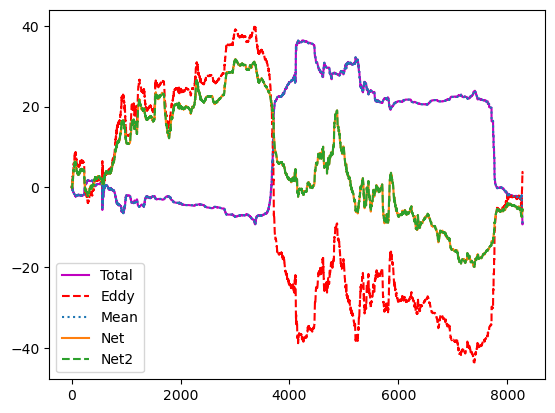

In [18]:
cumsum_total = np.cumsum(net_heat_transp_4km.mean('ocean_time').sum('s_rho'),axis=-1)*rho0*Cp*1e-12
cumsum_eddy = np.cumsum(np.nanmean(np.nansum(Eddy_transp_4km, axis=1),axis=0),axis=-1)*rho0*Cp*1e-12
cumsum_mean = np.cumsum(Mean_transp_4km.sum('s_rho'),axis=-1)*rho0*Cp*1e-12


plt.plot(cumsum_total,'-m',label='Total')
plt.plot(cumsum_eddy,'--r',label='Eddy')
plt.plot(cumsum_mean,':',label='Mean')
plt.plot(cumsum_mean+cumsum_eddy,'-',label='Net')
plt.plot(cumsum_total+cumsum_eddy,'--',label='Net2')
plt.legend()

# plt.xlim([0,2000])


### calculate net heat transport (Abs - Tf) across contour per density bin in $\sigma_2$

##### if not run before, run to calculate and save mean and eddy componentes of the CSHT:

In [ ]:
net_heat_transp_10km.shape

In [ ]:
# %%time

# # WAOM10

# # Eddy_transp_10km
# # Mean_transp_10km


# Mean_HT_10km_irho2 = np.empty((len(net_heat_transp_10km[:,0,0]),len_rho_grid2,len(net_heat_transp_10km[0,:,0]),len(net_heat_transp_10km[0,0,:])))
# Eddy_HT_10km_irho2 = np.empty((len(net_heat_transp_10km[:,0,0]),len_rho_grid2,len(net_heat_transp_10km[0,:,0]),len(net_heat_transp_10km[0,0,:])))

# for tt in np.arange(0,len(net_heat_transp_10km[:,0,0])):

#     for zz in np.arange(0,31):
#         sigma_tmp = sigma_2_10km[tt,zz,:]
    
#         # print(zz)
#         for irho in np.arange(0,len_rho_grid2):

#             mean_HT_tmp = ma.masked_where(np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2))), net_heat_transp_10km[tt,zz,:])
#             eddy_HT_tmp = ma.masked_where(np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2))), Eddy_transp_10km[tt,zz,:])

#             if irho == 0:
#                 eddy_HT_delta = eddy_HT_tmp.copy()
#                 eddy_HT_delta[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
#                 mean_HT_delta = mean_HT_tmp.copy()
#                 mean_HT_delta[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
#             elif irho == 1:
#                 eddy_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
#                 eddy_HT_delta = np.stack((eddy_HT_delta,eddy_HT_tmp), axis=0)
#                 mean_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
#                 mean_HT_delta = np.stack((mean_HT_delta,mean_HT_tmp), axis=0)
#             else:
#                 eddy_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
#                 eddy_HT_extradim = np.expand_dims(eddy_HT_tmp, axis=0)
#                 eddy_HT_delta = np.concatenate((eddy_HT_delta,eddy_HT_extradim), axis=0)
#                 mean_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
#                 mean_HT_extradim = np.expand_dims(mean_HT_tmp, axis=0)
#                 mean_HT_delta = np.concatenate((mean_HT_delta,mean_HT_extradim), axis=0)
        
#             # print(mean_HT_delta.shape, zz, mean_HT_tmp.shape)
#             del mean_HT_tmp
#             del eddy_HT_tmp
    
#         Mean_HT_10km_irho2[tt,:,zz,:] = mean_HT_delta
#         Eddy_HT_10km_irho2[tt,:,zz,:] = eddy_HT_delta



In [ ]:
# %%time

# # WAOM4

# # Eddy_transp_4km
# # Mean_transp_4km


# Mean_HT_4km_irho2 = np.empty((len(net_heat_transp_4km[:,0,0]),len_rho_grid2,len(net_heat_transp_4km[0,:,0]),len(net_heat_transp_4km[0,0,:])))
# Eddy_HT_4km_irho2 = np.empty((len(net_heat_transp_4km[:,0,0]),len_rho_grid2,len(net_heat_transp_4km[0,:,0]),len(net_heat_transp_4km[0,0,:])))

# for tt in np.arange(0,len(net_heat_transp_4km[:,0,0])):

#     for zz in np.arange(0,31):
#         sigma_tmp = sigma_2_4km[tt,zz,:]
    
#         # print(zz)
#         for irho in np.arange(0,len_rho_grid2):

#             mean_HT_tmp = ma.masked_where(np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2))), net_heat_transp_4km[tt,zz,:])
#             eddy_HT_tmp = ma.masked_where(np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2))), Eddy_transp_4km[tt,zz,:])

#             if irho == 0:
#                 eddy_HT_delta = eddy_HT_tmp.copy()
#                 eddy_HT_delta[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
#                 mean_HT_delta = mean_HT_tmp.copy()
#                 mean_HT_delta[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
#             elif irho == 1:
#                 eddy_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
#                 eddy_HT_delta = np.stack((eddy_HT_delta,eddy_HT_tmp), axis=0)
#                 mean_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
#                 mean_HT_delta = np.stack((mean_HT_delta,mean_HT_tmp), axis=0)
#             else:
#                 eddy_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
#                 eddy_HT_extradim = np.expand_dims(eddy_HT_tmp, axis=0)
#                 eddy_HT_delta = np.concatenate((eddy_HT_delta,eddy_HT_extradim), axis=0)
#                 mean_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
#                 mean_HT_extradim = np.expand_dims(mean_HT_tmp, axis=0)
#                 mean_HT_delta = np.concatenate((mean_HT_delta,mean_HT_extradim), axis=0)
        
#             # print(mean_HT_delta.shape, zz, mean_HT_tmp.shape)
#             del mean_HT_tmp
#             del eddy_HT_tmp
    
#         Mean_HT_4km_irho2[tt,:,zz,:] = mean_HT_delta
#         Eddy_HT_4km_irho2[tt,:,zz,:] = eddy_HT_delta


In [ ]:
# %%time

# # WAOM4

# # Eddy_transp_4kmNT
# # Mean_transp_4kmNT


# Mean_HT_4kmNT_irho2 = np.empty((len(net_heat_transp_4kmNT[:,0,0]),len_rho_grid2,len(net_heat_transp_4kmNT[0,:,0]),len(net_heat_transp_4kmNT[0,0,:])))
# Eddy_HT_4kmNT_irho2 = np.empty((len(net_heat_transp_4kmNT[:,0,0]),len_rho_grid2,len(net_heat_transp_4kmNT[0,:,0]),len(net_heat_transp_4kmNT[0,0,:])))

# for tt in np.arange(0,len(net_heat_transp_4kmNT[:,0,0])):

#     for zz in np.arange(0,31):
#         sigma_tmp = sigma_2_4kmNT[tt,zz,:]
    
#         # print(zz)
#         for irho in np.arange(0,len_rho_grid2):

#             mean_HT_tmp = ma.masked_where(np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2))), net_heat_transp_4kmNT[tt,zz,:])
#             eddy_HT_tmp = ma.masked_where(np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2))), Eddy_transp_4kmNT[tt,zz,:])

#             if irho == 0:
#                 eddy_HT_delta = eddy_HT_tmp.copy()
#                 eddy_HT_delta[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
#                 mean_HT_delta = mean_HT_tmp.copy()
#                 mean_HT_delta[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
#             elif irho == 1:
#                 eddy_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
#                 eddy_HT_delta = np.stack((eddy_HT_delta,eddy_HT_tmp), axis=0)
#                 mean_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
#                 mean_HT_delta = np.stack((mean_HT_delta,mean_HT_tmp), axis=0)
#             else:
#                 eddy_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
#                 eddy_HT_extradim = np.expand_dims(eddy_HT_tmp, axis=0)
#                 eddy_HT_delta = np.concatenate((eddy_HT_delta,eddy_HT_extradim), axis=0)
#                 mean_HT_tmp[np.logical_or(sigma_tmp <= (rho_grid2[irho]-(0.025/2)),sigma_tmp > (rho_grid2[irho]+(0.025/2)))] = np.nan
#                 mean_HT_extradim = np.expand_dims(mean_HT_tmp, axis=0)
#                 mean_HT_delta = np.concatenate((mean_HT_delta,mean_HT_extradim), axis=0)
        
#             # print(mean_HT_delta.shape, zz, mean_HT_tmp.shape)
#             del mean_HT_tmp
#             del eddy_HT_tmp
    
#         Mean_HT_4kmNT_irho2[tt,:,zz,:] = mean_HT_delta
#         Eddy_HT_4kmNT_irho2[tt,:,zz,:] = eddy_HT_delta


In [ ]:
# # save to netcdf file:
# coordinatesD=dict(ocean_time=months, rho_grid=(['rho_grid'], rho_grid2), s_rho=(['s_rho'], np.arange(0,31)),
#                     contour_index_array=(['contour_index_array'], np.arange(0,len(net_heat_transp_10km[0,0,:]))))
# Mean_HT_10km_irho2_xr = xr.DataArray(Mean_HT_10km_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])
# Eddy_HT_10km_irho2_xr = xr.DataArray(Eddy_HT_10km_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])


# files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
# Mean_HT_10km_irho2_xr.to_netcdf(files_path + 'WAOM10_MeanHT_CF_daily', mode='w', format="NETCDF4")
# Eddy_HT_10km_irho2_xr.to_netcdf(files_path + 'WAOM10_EddyHT_CF_daily', mode='w', format="NETCDF4")

# coordinatesD=dict(ocean_time=months, rho_grid=(['rho_grid'], rho_grid2), s_rho=(['s_rho'], np.arange(0,31)),
#                     contour_index_array=(['contour_index_array'], np.arange(0,len(net_heat_transp_4km[0,0,:]))))
# Mean_HT_4km_irho2_xr = xr.DataArray(Mean_HT_4km_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])
# Eddy_HT_4km_irho2_xr = xr.DataArray(Eddy_HT_4km_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])


# files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
# Mean_HT_4km_irho2_xr.to_netcdf(files_path + 'WAOM4_MeanHT_CF_daily', mode='w', format="NETCDF4")
# Eddy_HT_4km_irho2_xr.to_netcdf(files_path + 'WAOM4_EddyHT_CF_daily', mode='w', format="NETCDF4")

# coordinatesD=dict(ocean_time=months, rho_grid=(['rho_grid'], rho_grid2), s_rho=(['s_rho'], np.arange(0,31)),
#                     contour_index_array=(['contour_index_array'], np.arange(0,len(net_heat_transp_4kmNT[0,0,:]))))
# Mean_HT_4kmNT_irho2_xr = xr.DataArray(Mean_HT_4kmNT_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])
# Eddy_HT_4kmNT_irho2_xr = xr.DataArray(Eddy_HT_4kmNT_irho2, coords = coordinatesD, dims = ['ocean_time','rho_grid','s_rho','contour_index_array'])


# files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
# Mean_HT_4kmNT_irho2_xr.to_netcdf(files_path + 'WAOM4_notides_MeanHT_CF_daily', mode='w', format="NETCDF4")
# Eddy_HT_4kmNT_irho2_xr.to_netcdf(files_path + 'WAOM4_notides_EddyHT_CF_daily', mode='w', format="NETCDF4")

##### if run before, load saved mean and eddy components of the CSHT:

In [ ]:
%%time

files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'

dx=xr.open_dataset(files_path + 'WAOM10_MeanHT_CF_daily', mode='r', format="NETCDF4")
Mean_HT_10km_irho2 = dx.variables["__xarray_dataarray_variable__"]
dx.close()
dx=xr.open_dataset(files_path + 'WAOM10_EddyHT_CF_daily', mode='r', format="NETCDF4")
Eddy_HT_10km_irho2 = dx.variables["__xarray_dataarray_variable__"]
dx.close()

dx=xr.open_dataset(files_path + 'WAOM4_MeanHT_CF_daily', mode='r', format="NETCDF4")
Mean_HT_4km_irho2 = dx.variables["__xarray_dataarray_variable__"]
dx.close()
dx=xr.open_dataset(files_path + 'WAOM4_EddyHT_CF_daily', mode='r', format="NETCDF4")
Eddy_HT_4km_irho2 = dx.variables["__xarray_dataarray_variable__"]
dx.close()

dx=xr.open_dataset(files_path + 'WAOM4_notides_MeanHT_CF_daily', mode='r', format="NETCDF4")
Mean_HT_4kmNT_irho2 = dx.variables["__xarray_dataarray_variable__"]
dx.close()
dx=xr.open_dataset(files_path + 'WAOM4_notides_EddyHT_CF_daily', mode='r', format="NETCDF4")
Eddy_HT_4kmNT_irho2 = dx.variables["__xarray_dataarray_variable__"]
dx.close()

Mean_HT_10km_irho2.load()
Eddy_HT_10km_irho2.load()
Mean_HT_4km_irho2.load()
Eddy_HT_4km_irho2.load()
Mean_HT_4kmNT_irho2.load()
Eddy_HT_4kmNT_irho2.load()

In [ ]:
# %%time
# Net_HT_10km_irho2 = Mean_HT_10km_irho2+Eddy_HT_10km_irho2
# Net_HT_4km_irho2 = Mean_HT_4km_irho2+Eddy_HT_4km_irho2
# Net_HT_4kmNT_irho2 = Mean_HT_4kmNT_irho2+Eddy_HT_4kmNT_irho2

# Plots


In [ ]:
%%time

# 1) define variable cumsum along contour:

cumsum_eddy_10km = np.cumsum(np.nanmean(np.nansum(Eddy_transp_10km, axis=1),axis=0),axis=-1)*rho0*Cp*1e-12
cumsum_mean_10km = np.cumsum(Mean_transp_10km.sum('s_rho'),axis=-1)*rho0*Cp*1e-12
cumsum_eddy_4km = np.cumsum(np.nanmean(np.nansum(Eddy_transp_4km, axis=1),axis=0),axis=-1)*rho0*Cp*1e-12
cumsum_mean_4km = np.cumsum(Mean_transp_4km.sum('s_rho'),axis=-1)*rho0*Cp*1e-12
cumsum_eddy_4kmNT = np.cumsum(np.nanmean(np.nansum(Eddy_transp_4kmNT, axis=1),axis=0),axis=-1)*rho0*Cp*1e-12
cumsum_mean_4kmNT = np.cumsum(Mean_transp_4kmNT.sum('s_rho'),axis=-1)*rho0*Cp*1e-12


In [ ]:
%%time

# 2) calculate OHC depth-integrated:
temp3d_4km.load()
temp3d_4km_K = temp3d_4km+3.47
temp3d_vint_4km_annual = temp3d_4km_K.sum('s_rho').mean('ocean_time')*rho0*Cp
print(temp3d_vint_4km_annual.shape)


In [ ]:
# finding indexes position for subsectors boundaries

# print(lon_along_10km[422].values) # 140W
# print(lon_along_10km[751].values) # 90W
print(lon_along_10km[1298].values) # 60W
# print(lon_along_10km[1669].values) # 25W
# print(lon_along_10km[2305].values) # 60E


# ax1.plot([dist_along_10km[422].values,dist_along_10km[422].values],[-600,600],'-', color=[.3,.3,.3])     #140W               
# ax1.plot([dist_along_10km[751].values,dist_along_10km[751].values],[-600,600],'-', color=[.3,.3,.3])   # 90W                         
# ax1.plot([dist_along_10km[1298].values,dist_along_10km[1298].values],[-600,600],'-', color=[.3,.3,.3])   # 60W                         
# ax1.plot([dist_along_10km[1669].values,dist_along_10km[1669].values],[-600,600],'-', color=[.3,.3,.3])     # 25W
# ax1.plot([dist_along_10km[2305].values,dist_along_10km[2305].values],[-600,600],'-', color=[.3,.3,.3])     # 60E 

In [ ]:

fig = plt.figure(figsize=(12,7))

# 1)
ax1 = fig.add_subplot(211)
# ax1.text(2,75,'Annual mean and eddy heat transport',fontsize=16)
ax1.plot(dist_along_10km[:],np.zeros(cumsum_mean_10km[:].shape),'-', color=[.7,.7,.7], linewidth=0.5)
ax1.plot(dist_along_10km[:],cumsum_mean_10km+cumsum_eddy_10km,'--k', label='WAOM10', linewidth=1,alpha=0.7)
ax1.plot(dist_along_4km[0],cumsum_mean_4km[0]+cumsum_eddy_4km[0],'-k',label='WAOM4', linewidth=1.6) # plot just to add legend
ax1.plot(dist_along_4km[0],cumsum_mean_4kmNT[0]+cumsum_eddy_4kmNT[0],':k',label='WAOM4-NOTIDE', linewidth=1,alpha=0.7)  # plot just to add legend
ax1.legend(loc='lower left')
ax1.plot(dist_along_10km[:],cumsum_mean_10km,'--',color='dodgerblue', linewidth=1,alpha=0.6)
ax1.plot(dist_along_10km[:],cumsum_eddy_10km,'--',color='orangered',linewidth=1,alpha=0.6)
ax1.plot(dist_along_10km[:],cumsum_mean_10km+cumsum_eddy_10km,'--k', linewidth=1,alpha=0.7)

ax1.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax1.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax1.set_xlim(0, dist_along_10km[-1])

ax1b = ax1.twiny()
ax1b.plot(dist_along_4km[:],cumsum_mean_4km+cumsum_eddy_4km,'-k',label='SRT', linewidth=1.6)
ax1b.plot(dist_along_4km[:],cumsum_eddy_4km,'-',label='EIT',color='orangered',linewidth=1.6)
ax1b.plot(dist_along_4km[:],cumsum_mean_4km,'-',label='ADV',color='dodgerblue',linewidth=1.6)
ax1b.legend(loc='upper left')
ax1b.plot(dist_along_4km[:],cumsum_mean_4kmNT+cumsum_eddy_4kmNT,'-k', linewidth=1,alpha=0.7)
ax1b.plot(dist_along_4km[:],cumsum_mean_4kmNT,':',color='dodgerblue',linewidth=1,alpha=0.6)
ax1b.plot(dist_along_4km[:],cumsum_eddy_4kmNT,':',color='orangered',linewidth=1,alpha=0.6)
ax1b.set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax1b.set_xticklabels((''))
ax1b.set_xlim(0, dist_along_4km[-1])
ax1b.set_title('Cross-calving front heat transport vertically-integrated')

ymin=-150
ymax=150
ax1.set_ylim(ymin,ymax)
ax1.text(dist_along_10km[422].values-2.5,ymin-50,'$\it{Ross}$',fontsize=12, color='k')       
ax1.plot([dist_along_10km[422].values,dist_along_10km[422].values],[ymin,ymax],'-', color=[.3,.3,.3])     #140W    
ax1.text(dist_along_10km[422].values+.15,ymin-50,'$\it{West\ Ant.}$',fontsize=12, color='k')        
ax1.plot([dist_along_10km[751].values,dist_along_10km[751].values],[ymin,ymax],'-', color=[.3,.3,.3])   # 90W  
ax1.text(dist_along_10km[751].values+.5,ymin-50,'$\it{Ant.\ Penins.}$',fontsize=12, color='k')        
ax1.plot([dist_along_10km[1298].values,dist_along_10km[1298].values],[ymin,ymax],'-', color=[.3,.3,.3])   # 60W                         
ax1.text(dist_along_10km[1298].values+.5,ymin-50,'$\it{FRIS}$',fontsize=12, color='k')        
ax1.plot([dist_along_10km[1669].values,dist_along_10km[1669].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 25W
ax1.text(dist_along_10km[1669].values+1.25,ymin-50,'$\it{Maud\ Land}$',fontsize=12, color='k')        
ax1.plot([dist_along_10km[2305].values,dist_along_10km[2305].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 60E 
ax1.text(dist_along_10km[2305].values+2,ymin-50,'$\it{East\ Ant.}$',fontsize=12, color='k')        



In [ ]:
## paper figure with:
# 1) map of OHC depth-integrated
# 2) plot of vertically-integrated  OHT (mean+eddy) across 1500m
# 3) add OHT across CF line below.

### fig, ax = plt.subplots(nrows=2, figsize = (12, 7))
fig = plt.figure(figsize=(12,7))

# 1) map:
jst= 100
jen=-1
ist=0
ien=-1
tmin = 0
tmax = 0.5
# call cartopy projection
proj = ccrs.PlateCarree(central_longitude=-24)
ax2 = fig.add_subplot(211, projection=proj)
ct1=plt.pcolormesh(lon_rho_4km[jst:jen,ist:ien].values,lat_rho_4km[jst:jen,ist:ien].values,temp3d_vint_4km_annual[jst:jen,ist:ien]*1e-9, transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
plt.scatter(lon_along_4km,lat_along_4km, s=.8, alpha=0.4, color='turquoise',label='1500m isobath', transform=ccrs.PlateCarree());
plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=.8, alpha=0.4, color='lightskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.title('WAOM4, depth-integrated ocean heat content')



# ax2.gridlines(draw_labels=True,linewidth=.1)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color=[.3,.3,.3], alpha=0.75, linestyle=':')
gl.xlabels_top = False
gl.ylabels_left = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-160, -120, -80, -40, 0, 40, 80, 120, 156])
gl.ylocator = mticker.FixedLocator([-65, -70, -75, -80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 10, 'color': 'k'}
# gl.ylabel_style = {'size': 9, 'color': 'k'}

ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
# plt.colorbar(ct1, location="right")
ax2.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ratio = .2
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax1 = fig.add_axes([0.91, 0.575,  0.01, 0.26])
fig.colorbar(ct1, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('GJ')#, labelpad=-35)

## 2) Vert.integ. HT:
#
ax1 = fig.add_subplot(212)
# ax1.text(2,75,'Annual mean and eddy heat transport',fontsize=16)
ax1.plot(dist_along_10km[:],np.zeros(cumsum_mean_10km[:].shape),'-', color=[.7,.7,.7], linewidth=0.5)
ax1.plot(dist_along_10km[:],cumsum_mean_10km+cumsum_eddy_10km,'--k', label='WAOM10', linewidth=1,alpha=0.7)
ax1.plot(dist_along_4km[0],cumsum_mean_4km[0]+cumsum_eddy_4km[0],'-k',label='WAOM4', linewidth=1.6) # plot just to add legend
ax1.plot(dist_along_4km[0],cumsum_mean_4kmNT[0]+cumsum_eddy_4kmNT[0],':k',label='WAOM4-NOTIDE', linewidth=1,alpha=0.7)  # plot just to add legend
ax1.legend(loc='lower left')
ax1.plot(dist_along_10km[:],cumsum_mean_10km,'--',color='dodgerblue', linewidth=1,alpha=0.6)
ax1.plot(dist_along_10km[:],cumsum_eddy_10km,'--',color='orangered',linewidth=1,alpha=0.6)
ax1.plot(dist_along_10km[:],cumsum_mean_10km+cumsum_eddy_10km,'--k', linewidth=1,alpha=0.7)

ax1.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax1.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax1.set_xlim(0, dist_along_10km[-1])

ax1b = ax1.twiny()
ax1b.plot(dist_along_4km[:],cumsum_mean_4km+cumsum_eddy_4km,'-k',label='SRT', linewidth=1.6)
ax1b.plot(dist_along_4km[:],cumsum_eddy_4km,'-',label='EIT',color='orangered',linewidth=1.6)
ax1b.plot(dist_along_4km[:],cumsum_mean_4km,'-',label='ADV',color='dodgerblue',linewidth=1.6)
ax1b.legend(loc='upper left')
ax1b.plot(dist_along_4km[:],cumsum_mean_4kmNT+cumsum_eddy_4kmNT,'-k', linewidth=1,alpha=0.7)
ax1b.plot(dist_along_4km[:],cumsum_mean_4kmNT,':',color='dodgerblue',linewidth=1,alpha=0.6)
ax1b.plot(dist_along_4km[:],cumsum_eddy_4kmNT,':',color='orangered',linewidth=1,alpha=0.6)
ax1b.set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax1b.set_xticklabels((''))
ax1b.set_xlim(0, dist_along_4km[-1])
ax1b.set_title('Cross-calving front heat transport vertically-integrated')

ymin=-150
ymax=150
ax1.set_ylim(ymin,ymax)
ax1.text(dist_along_10km[422].values-2.5,ymin-50,'$\it{Ross}$',fontsize=12, color='k')       
ax1.plot([dist_along_10km[422].values,dist_along_10km[422].values],[ymin,ymax],'-', color=[.3,.3,.3])     #140W    
ax1.text(dist_along_10km[422].values+.15,ymin-50,'$\it{West\ Ant.}$',fontsize=12, color='k')        
ax1.plot([dist_along_10km[751].values,dist_along_10km[751].values],[ymin,ymax],'-', color=[.3,.3,.3])   # 90W  
ax1.text(dist_along_10km[751].values+.5,ymin-50,'$\it{Ant.\ Penins.}$',fontsize=12, color='k')        
ax1.plot([dist_along_10km[1298].values,dist_along_10km[1298].values],[ymin,ymax],'-', color=[.3,.3,.3])   # 60W                         
ax1.text(dist_along_10km[1298].values+.5,ymin-50,'$\it{FRIS}$',fontsize=12, color='k')        
ax1.plot([dist_along_10km[1669].values,dist_along_10km[1669].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 25W
ax1.text(dist_along_10km[1669].values+1.25,ymin-50,'$\it{Maud\ Land}$',fontsize=12, color='k')        
ax1.plot([dist_along_10km[2305].values,dist_along_10km[2305].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 60E 
ax1.text(dist_along_10km[2305].values+2,ymin-50,'$\it{East\ Ant.}$',fontsize=12, color='k')   

plt.savefig(fig_path + 'Figure1_OHCvint+_MeanEddy_HTcumsum_crossCF.png', bbox_inches='tight', dpi=300)
# plt.show()

In [ ]:
# define dist and z coordinates for pcolormesh plot:
[lon_along_axis_10km, Zaxis_10km] = np.meshgrid(lon_along_10km, np.arange(0,31))
[lon_along_axis_4km, Zaxis_4km] = np.meshgrid(lon_along_4km, np.arange(0,31))


In [ ]:
rho_grid2_01 = np.arange(36.2,37.4,0.05) # for sigma-2
print(rho_grid2[np.arange(32,34)])

In [ ]:
0.69*100/0.86

In [ ]:
2.23*100/1.09

In [ ]:
2.83*100/2.89

### plot mean, eddy, and mean-eddy sections (depth x along_contour), binned & integrated over some density bins

## Plot section WAOM10

#### WAOM 10, MEAN HT

In [ ]:
# Annual average for density-cross-1500m transports:
# WAOM10
fig, ax = plt.subplots(nrows=6, figsize = (12, 15))
#ax[0].text(17,75,'Day = ' + str(tt*5),fontsize=12)
## ax[0].text(2,75,'$\sigma_{\Theta}$ = ' +  str(round(rho_grid2[ll],2)),fontsize=12)
# ax[0].text(2,75,'WAOM10: Annual avg mean heat transport',fontsize=16)

ll=np.arange(26,28) #17 # 
cht = ax[0].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km.fillna(0), axis=0),np.nanmean(np.nansum(Mean_HT_10km_irho2[:,ll,:,:], axis=1),  axis=0)*rho0*Cp, vmin=-1e11, vmax=1e11, cmap='coolwarm')
ax[0].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[0].set_xlim(0, lon_along_10km[-1])
# ax[0].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
ax[0].text(1,-2500,'$\sigma_{2}$ = 36.5:36.875 kg m$^{-3}$',fontsize=14)
ax[0].set_yscale('symlog',base = 2, linthresh=700)
ax[0].set_ylabel('Depth (m, symlog$_2$)')
ax[0].set_yticklabels(['-2000','-1000','-500'])
ax[0].set_aspect('auto')
ax[0].tick_params(labelsize=12)

ll=np.arange(28,30) #18
cht = ax[1].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km.fillna(0), axis=0),np.nanmean(np.nansum(Mean_HT_10km_irho2[:,ll,:,:], axis=1),  axis=0)*rho0*Cp, vmin=-1e11, vmax=1e11, cmap='coolwarm')
ax[1].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[1].set_xlim(0, lon_along_10km[-1])
ax[1].text(1,-2500,'$\sigma_{2}$ = 36.9:36.925 kg m$^{-3}$',fontsize=14)
ax[1].set_yscale('symlog',base = 2, linthresh=700)
ax[1].set_ylabel('Depth (m, symlog$_2$)')
ax[1].set_yticklabels(['-2000','-1000','-500'])
ax[1].set_aspect('auto')
ax[1].tick_params(labelsize=12)

ll=np.arange(30,32) #19
cht = ax[2].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km.fillna(0), axis=0),np.nanmean(np.nansum(Mean_HT_10km_irho2[:,ll,:,:], axis=1),  axis=0)*rho0*Cp, vmin=-1e11, vmax=1e11, cmap='coolwarm')
ax[2].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[2].set_xlim(0, lon_along_10km[-1])
ax[2].text(1,-2500,'$\sigma_{2}$ = 36.95:36.975 kg m$^{-3}$',fontsize=14)
ax[2].set_yscale('symlog',base = 2, linthresh=700)
ax[2].set_ylabel('Depth (m, symlog$_2$)')
ax[2].set_yticklabels(['-2000','-1000','-500'])
ax[2].set_aspect('auto')
ax[2].tick_params(labelsize=12)

ll=np.arange(32,34) #20
cht = ax[3].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km.fillna(0), axis=0),np.nanmean(np.nansum(Mean_HT_10km_irho2[:,ll,:,:], axis=1),  axis=0)*rho0*Cp, vmin=-1e11, vmax=1e11, cmap='coolwarm')
ax[3].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
ax[3].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                            '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[3].set_xlim(0, lon_along_10km[-1])
ax[3].text(1,-2500,'$\sigma_{2}$ = 37:37.025 kg m$^{-3}$',fontsize=14)
ax[3].set_yscale('symlog',base = 2, linthresh=700)
ax[3].set_ylabel('Depth (m, symlog$_2$)')
ax[3].set_yticklabels(['-2000','-1000','-500'])
ax[3].set_aspect('auto')
ax[3].tick_params(labelsize=12)

ll=np.arange(34,36) #21
cht = ax[4].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km.fillna(0), axis=0),np.nanmean(np.nansum(Mean_HT_10km_irho2[:,ll,:,:], axis=1),  axis=0)*rho0*Cp, vmin=-1e11, vmax=1e11, cmap='coolwarm')
ax[4].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
ax[4].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[4].set_xlim(0, lon_along_10km[-1])
ax[4].text(1,-2500,'$\sigma_{2}$ = 37.05:37.075 kg m$^{-3}$',fontsize=14)
ax[4].set_yscale('symlog',base = 2, linthresh=700)
ax[4].set_ylabel('Depth (m, symlog$_2$)')
ax[4].set_yticklabels(['-2000','-1000','-500'])
ax[4].set_aspect('auto')
ax[4].tick_params(labelsize=12)
 
ll=np.arange(36,38) #22
cht = ax[5].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km.fillna(0), axis=0),np.nanmean(np.nansum(Mean_HT_10km_irho2[:,ll,:,:], axis=1),  axis=0)*rho0*Cp, vmin=-1e11, vmax=1e11, cmap='coolwarm')
ax[5].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
ax[5].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[5].set_xlim(0, lon_along_10km[-1])
ax[5].text(1,-2500,'$\sigma_{2}$ = 37.1:37.125 kg m$^{-3}$',fontsize=14)
ax[5].set_yscale('symlog',base = 2, linthresh=700)
ax[5].set_ylabel('Depth (m, symlog$_2$)')
ax[5].set_yticklabels(['-2000','-1000','-500'])
ax[5].set_aspect('auto')
ax[5].tick_params(labelsize=12)
 
cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
cb = plt.colorbar(cht, cax=cax1, orientation='vertical')
cb.ax.set_ylabel('Heat flux (W)', fontsize=14)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10_Mean_HT_crossCF_rho2_annual.png"
plt.savefig(name_fig, dpi=300)


#### WAOM 10, EDDY HT

In [ ]:
# Annual average for density-cross-1500m transports:
# WAOM10
fig, ax = plt.subplots(nrows=6, figsize = (12, 15))
#ax[0].text(17,75,'Day = ' + str(tt*5),fontsize=12)
## ax[0].text(2,75,'$\sigma_{\Theta}$ = ' +  str(round(rho_grid2[ll],2)),fontsize=12)
# ax[0].text(2,75,'WAOM10: Annual avg mean heat transport',fontsize=16)

ll=np.arange(26,28) #17 # 
cht = ax[0].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km.fillna(0), axis=0),np.nanmean(np.nansum(Eddy_HT_10km_irho2[:,ll,:,:], axis=1),  axis=0)*rho0*Cp, vmin=-1e11, vmax=1e11, cmap='coolwarm')
ax[0].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[0].set_xlim(0, lon_along_10km[-1])
# ax[0].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
ax[0].text(1,-2500,'$\sigma_{2}$ = 36.5:36.875 kg m$^{-3}$',fontsize=14)
ax[0].set_yscale('symlog',base = 2, linthresh=700)
ax[0].set_ylabel('Depth (m, symlog$_2$)')
ax[0].set_yticklabels(['-2000','-1000','-500'])
ax[0].set_aspect('auto')
ax[0].tick_params(labelsize=12)

ll=np.arange(28,30) #18
cht = ax[1].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km.fillna(0), axis=0),np.nanmean(np.nansum(Eddy_HT_10km_irho2[:,ll,:,:], axis=1),  axis=0)*rho0*Cp, vmin=-1e11, vmax=1e11, cmap='coolwarm')
ax[1].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[1].set_xlim(0, lon_along_10km[-1])
ax[1].text(1,-2500,'$\sigma_{2}$ = 36.9:36.925 kg m$^{-3}$',fontsize=14)
ax[1].set_yscale('symlog',base = 2, linthresh=700)
ax[1].set_ylabel('Depth (m, symlog$_2$)')
ax[1].set_yticklabels(['-2000','-1000','-500'])
ax[1].set_aspect('auto')
ax[1].tick_params(labelsize=12)

ll=np.arange(30,32) #19
cht = ax[2].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km.fillna(0), axis=0),np.nanmean(np.nansum(Eddy_HT_10km_irho2[:,ll,:,:], axis=1),  axis=0)*rho0*Cp, vmin=-1e11, vmax=1e11, cmap='coolwarm')
ax[2].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[2].set_xlim(0, lon_along_10km[-1])
ax[2].text(1,-2500,'$\sigma_{2}$ = 36.95:36.975 kg m$^{-3}$',fontsize=14)
ax[2].set_yscale('symlog',base = 2, linthresh=700)
ax[2].set_ylabel('Depth (m, symlog$_2$)')
ax[2].set_yticklabels(['-2000','-1000','-500'])
ax[2].set_aspect('auto')
ax[2].tick_params(labelsize=12)

ll=np.arange(32,34) #20
cht = ax[3].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km.fillna(0), axis=0),np.nanmean(np.nansum(Eddy_HT_10km_irho2[:,ll,:,:], axis=1),  axis=0)*rho0*Cp, vmin=-1e11, vmax=1e11, cmap='coolwarm')
ax[3].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
ax[3].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                            '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[3].set_xlim(0, lon_along_10km[-1])
ax[3].text(1,-2500,'$\sigma_{2}$ = 37:37.025 kg m$^{-3}$',fontsize=14)
ax[3].set_yscale('symlog',base = 2, linthresh=700)
ax[3].set_ylabel('Depth (m, symlog$_2$)')
ax[3].set_yticklabels(['-2000','-1000','-500'])
ax[3].set_aspect('auto')
ax[3].tick_params(labelsize=12)

ll=np.arange(34,36) #21
cht = ax[4].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km.fillna(0), axis=0),np.nanmean(np.nansum(Eddy_HT_10km_irho2[:,ll,:,:], axis=1),  axis=0)*rho0*Cp, vmin=-1e11, vmax=1e11, cmap='coolwarm')
ax[4].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
ax[4].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[4].set_xlim(0, lon_along_10km[-1])
ax[4].text(1,-2500,'$\sigma_{2}$ = 37.05:37.075 kg m$^{-3}$',fontsize=14)
ax[4].set_yscale('symlog',base = 2, linthresh=700)
ax[4].set_ylabel('Depth (m, symlog$_2$)')
ax[4].set_yticklabels(['-2000','-1000','-500'])
ax[4].set_aspect('auto')
ax[4].tick_params(labelsize=12)
 
ll=np.arange(36,38) #22
cht = ax[5].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km.fillna(0), axis=0),np.nanmean(np.nansum(Eddy_HT_10km_irho2[:,ll,:,:], axis=1),  axis=0)*rho0*Cp, vmin=-1e11, vmax=1e11, cmap='coolwarm')
ax[5].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
ax[5].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[5].set_xlim(0, lon_along_10km[-1])
ax[5].text(1,-2500,'$\sigma_{2}$ = 37.1:37.125 kg m$^{-3}$',fontsize=14)
ax[5].set_yscale('symlog',base = 2, linthresh=700)
ax[5].set_ylabel('Depth (m, symlog$_2$)')
ax[5].set_yticklabels(['-2000','-1000','-500'])
ax[5].set_aspect('auto')
ax[5].tick_params(labelsize=12)
 
cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
cb = plt.colorbar(cht, cax=cax1, orientation='vertical')
cb.ax.set_ylabel('Heat flux (W)', fontsize=14)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10_Eddy_HT_crossCF_rho2_annual.png"
plt.savefig(name_fig, dpi=300)


#### WAOM 10, MEAN+EDDY HT

In [ ]:
# mean+eddy
Net_HT_10km_irho2 = Mean_HT_10km_irho2 + Eddy_HT_10km_irho2

In [ ]:
# Annual average for density-cross-1500m transports:
# WAOM10
fig, ax = plt.subplots(nrows=6, figsize = (12, 15))
#ax[0].text(17,75,'Day = ' + str(tt*5),fontsize=12)
## ax[0].text(2,75,'$\sigma_{\Theta}$ = ' +  str(round(rho_grid2[ll],2)),fontsize=12)
# ax[0].text(2,75,'WAOM10: Annual avg net heat transport (mean + eddy)',fontsize=16)

ll=np.arange(26,28) #17 # 
cht = ax[0].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km.fillna(0), axis=0),\
                        np.nanmean(np.nansum(Net_HT_10km_irho2[:,ll,:,:], axis=1), axis=0)*rho0*Cp*1e-12, vmin=-.01, vmax=.01, cmap='coolwarm')
ax[0].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[0].set_xlim(0, lon_along_10km[-1])
# ax[0].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
ax[0].text(1,-2500,'$\sigma_{2}$ = 36.5:36.875 kg m$^{-3}$',fontsize=14)
ax[0].set_yscale('symlog',base = 2, linthresh=700)
ax[0].set_ylabel('Depth (m, symlog$_2$)')
ax[0].set_yticklabels(['-2000','-1000','-500'])
ax[0].set_aspect('auto')
ax[0].tick_params(labelsize=12)

ll=np.arange(28,30) #18
cht = ax[1].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km.fillna(0), axis=0),\
                        np.nanmean(np.nansum(Net_HT_10km_irho2[:,ll,:,:], axis=1), axis=0)*rho0*Cp*1e-12, vmin=-.01, vmax=.01, cmap='coolwarm')
ax[1].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[1].set_xlim(0, lon_along_10km[-1])
ax[1].text(1,-2500,'$\sigma_{2}$ = 36.9:36.925 kg m$^{-3}$',fontsize=14)
ax[1].set_yscale('symlog',base = 2, linthresh=700)
ax[1].set_ylabel('Depth (m, symlog$_2$)')
ax[1].set_yticklabels(['-2000','-1000','-500'])
ax[1].set_aspect('auto')
ax[1].tick_params(labelsize=12)

ll=np.arange(30,32) #19
cht = ax[2].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km.fillna(0), axis=0),\
                        np.nanmean(np.nansum(Net_HT_10km_irho2[:,ll,:,:], axis=1), axis=0)*rho0*Cp*1e-12, vmin=-.01, vmax=.01, cmap='coolwarm')
ax[2].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[2].set_xlim(0, lon_along_10km[-1])
ax[2].text(1,-2500,'$\sigma_{2}$ = 36.95:36.975 kg m$^{-3}$',fontsize=14)
ax[2].set_yscale('symlog',base = 2, linthresh=700)
ax[2].set_ylabel('Depth (m, symlog$_2$)')
ax[2].set_yticklabels(['-2000','-1000','-500'])
ax[2].set_aspect('auto')
ax[2].tick_params(labelsize=12)

ll=np.arange(32,34) #20
cht = ax[3].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km.fillna(0), axis=0),\
                        np.nanmean(np.nansum(Net_HT_10km_irho2[:,ll,:,:], axis=1), axis=0)*rho0*Cp*1e-12, vmin=-.01, vmax=.01, cmap='coolwarm')
ax[3].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
ax[3].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                            '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[3].set_xlim(0, lon_along_10km[-1])
ax[3].text(1,-2500,'$\sigma_{2}$ = 37:37.025 kg m$^{-3}$',fontsize=14)
ax[3].set_yscale('symlog',base = 2, linthresh=700)
ax[3].set_ylabel('Depth (m, symlog$_2$)')
ax[3].set_yticklabels(['-2000','-1000','-500'])
ax[3].set_aspect('auto')
ax[3].tick_params(labelsize=12)

ll=np.arange(34,36) #21
cht = ax[4].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km.fillna(0), axis=0),\
                        np.nanmean(np.nansum(Net_HT_10km_irho2[:,ll,:,:], axis=1), axis=0)*rho0*Cp*1e-12, vmin=-.01, vmax=.01, cmap='coolwarm')
ax[4].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
ax[4].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[4].set_xlim(0, lon_along_10km[-1])
ax[4].text(1,-2500,'$\sigma_{2}$ = 37.05:37.075 kg m$^{-3}$',fontsize=14)
ax[4].set_yscale('symlog',base = 2, linthresh=700)
ax[4].set_ylabel('Depth (m, symlog$_2$)')
ax[4].set_yticklabels(['-2000','-1000','-500'])
ax[4].set_aspect('auto')
ax[4].tick_params(labelsize=12)
 
ll=np.arange(36,38) #22
cht = ax[5].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km.fillna(0), axis=0),\
                        np.nanmean(np.nansum(Net_HT_10km_irho2[:,ll,:,:], axis=1), axis=0)*rho0*Cp*1e-12, vmin=-.01, vmax=.01, cmap='coolwarm')
ax[5].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
ax[5].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[5].set_xlim(0, lon_along_10km[-1])
ax[5].text(1,-2500,'$\sigma_{2}$ = 37.1:37.125 kg m$^{-3}$',fontsize=14)
ax[5].set_yscale('symlog',base = 2, linthresh=700)
ax[5].set_ylabel('Depth (m, symlog$_2$)')
ax[5].set_yticklabels(['-2000','-1000','-500'])
ax[5].set_aspect('auto')
ax[5].tick_params(labelsize=12)
 
cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
cb = plt.colorbar(cht, cax=cax1, orientation='vertical')
cb.ax.set_ylabel('Heat transport (W)', fontsize=14)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10_Net_HT_crossCF_rho2_annual.png"
plt.savefig(name_fig, dpi=300)


## Doing some TS-diagrams:

In [ ]:
# make grid for density contours
smin = 30 - (0.01 * 30)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 36. + (0.01 * 36.)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -4. + (0.1 * -4.)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 5 + (0.1 * 5.)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 30
ydim = 20
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-4,5,ydim)
si = np.linspace(30,36,xdim)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=gsw.rho(si[i],ti[j],2000) # sigma-2000
# Substract 1000 to convert to sigma-2
dens = dens - 1000

In [ ]:
import cmocean

fig, ax = plt.subplots(nrows=3, figsize = (5, 10))
# normal isopycnals
for aa in range(0,3):
    CS1 = ax[aa].contour(Si,Ti,dens.transpose(), levels=np.arange(35.5,37.2,.1),linestyles='solid', colors=[(.8,0.8,0.8)], linewidth=0.1)
    ax[aa].clabel(CS1, CS1.levels, inline=True, fontsize=10)
    CS2 = ax[aa].contour(Si,Ti,dens.transpose(), levels=np.arange(37.2,38,.1),linestyles='solid', colors=[(.8,0.8,0.8)], linewidth=0.1)
    ax[aa].clabel(CS2, CS2.levels, inline=True, fontsize=10)
    # specific isopycnals
    # cc1 = ax[aa].contour(Si,Ti,dens.transpose(), levels=[36.85],linestyles='solid', colors='darkgrey', linewidth=0.1)
    # ax[aa].clabel(cc1, cc1.levels, inline=True, fontsize=10)
    # cc2 = ax[aa].contour(Si,Ti,dens.transpose(), levels=[36.9],linestyles='solid', colors='khaki', linewidth=0.1)
    # ax[aa].clabel(cc2, cc2.levels, inline=True, fontsize=10)
    # cc3 = ax[aa].contour(Si,Ti,dens.transpose(), levels=[36.95],linestyles='solid', colors='aqua', linewidth=0.1)
    # ax[aa].clabel(cc3, cc3.levels, inline=True, fontsize=10)
    # cc4 = ax[aa].contour(Si,Ti,dens.transpose(), levels=[37.0],linestyles='solid', colors='steelblue', linewidth=0.1)
    # ax[aa].clabel(cc4, cc4.levels, inline=True, fontsize=10)
    # cc5 = ax[aa].contour(Si,Ti,dens.transpose(), levels=[37.05],linestyles='solid', colors='darkorange', linewidth=0.1)
    # ax[aa].clabel(cc5, cc5.levels, inline=True, fontsize=10)
    # cc6 = ax[aa].contour(Si,Ti,dens.transpose(), levels=[37.1],linestyles='solid', colors='limegreen', linewidth=0.1)
    # ax[aa].clabel(cc6, cc6.levels, inline=True, fontsize=10)
    ax[aa].set_xlim([34.2,34.8])
    ax[aa].set_ylim([-3,2])
    ax[aa].set_ylabel('Temperature')
    if aa == 2:
        ax[aa].set_xlabel('Salinity')
        
sc = ax[0].scatter(np.nanmean(salt_10km,axis=0),np.nanmean(temp_10km,axis=0),
                 c=-np.nanmean(z_rho_10km,axis=0),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[0].text(34.3,-2.75,'WAOM10', fontsize=10, fontweight='bold')

sc = ax[1].scatter(np.nanmean(salt_4km,axis=0),np.nanmean(temp_4km,axis=0),
                 c=-np.nanmean(z_rho_4km,axis=0),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[1].text(34.3,-2.75,'WAOM4', fontsize=10, fontweight='bold')

sc = ax[2].scatter(np.nanmean(salt_4kmNT,axis=0),np.nanmean(temp_4kmNT,axis=0),
                 c=-np.nanmean(z_rho_4km,axis=0),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[2].text(34.3,-2.75,'WAOM4-NOTIDE', fontsize=10, fontweight='bold')

# - cbar horiz
# cbar_ax1 = fig.add_axes([0.12, 0.005, 0.785, 0.01])
# fig.colorbar(sc, cax=cbar_ax1, orientation='horizontal')
# cbar_ax1.set_xlabel('Depth (m)')
# - cbar vert
cbar_ax1 = fig.add_axes([0.8, 0.3, 0.01, 0.6])
fig.colorbar(sc, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Depth (m)')

plt.subplots_adjust(left=0.25, right=0.75, bottom=0.3, top=0.9)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10x4x4NT_TSdiag_1500m_rho2_annnual.png"
plt.savefig(name_fig, bbox_inches='tight', dpi=300)

# integrated over circumpolar domain per density classes:

In [ ]:
%%time

# - Calculate total sum per density bin:
# the order of the operations matter; averaging on time as last operat. hugely changes the directions of transport.

Sum_MeanHT_10km_sigma2 = np.empty(len(rho_grid2)) # 
Cumsum_MeanHT_10km_sigma2 = np.empty((len(rho_grid2),3027)) # 
for ll in np.arange(0,len(rho_grid2),1):
    Sum_MeanHT_10km_sigma2[ll] = np.nanmean(np.nansum(np.nansum(Mean_HT_10km_irho2[:,ll,:,:], axis=1),axis=1), axis=0) #SUM VERT LEV, SUM ALONG CONTOUR, MEAN TIME
    Cumsum_MeanHT_10km_sigma2[ll,:] = np.nanmean(np.cumsum(np.nansum(Mean_HT_10km_irho2[:,ll,:,:], axis=1),axis=1), axis=0) #SUM RHO_GRID, CUMSUM ALONG CONTOUR, MEAN TIME

Sum_MeanHT_4km_sigma2 = np.empty(len(rho_grid2)) # 
Cumsum_MeanHT_4km_sigma2 = np.empty((len(rho_grid2),8282)) # 
for ll in np.arange(0,len(rho_grid2),1):
    Sum_MeanHT_4km_sigma2[ll] = np.nanmean(np.nansum(np.nansum(Mean_HT_4km_irho2[:,ll,:,:], axis=1),axis=1), axis=0)
    Cumsum_MeanHT_4km_sigma2[ll,:] = np.nanmean(np.cumsum(np.nansum(Mean_HT_4km_irho2[:,ll,:,:], axis=1),axis=1), axis=0)


Sum_MeanHT_4kmNT_sigma2 = np.empty(len(rho_grid2)) # 
Cumsum_MeanHT_4kmNT_sigma2 = np.empty((len(rho_grid2),8282)) # 
for ll in np.arange(0,len(rho_grid2),1):
    Sum_MeanHT_4kmNT_sigma2[ll] = np.nanmean(np.nansum(np.nansum(Mean_HT_4kmNT_irho2[:,ll,:,:], axis=1),axis=1), axis=0)
    Cumsum_MeanHT_4kmNT_sigma2[ll,:] = np.nanmean(np.cumsum(np.nansum(Mean_HT_4kmNT_irho2[:,ll,:,:], axis=1),axis=1), axis=0)



In [ ]:
%%time

# - Calculate total sum per density bin:
# the order of the operations matter; averaging on time as last operat. hugely changes the directions of transport.

Sum_EddyHT_10km_sigma2 = np.empty(len(rho_grid2)) # 
Cumsum_EddyHT_10km_sigma2 = np.empty((len(rho_grid2),3027)) # 
for ll in np.arange(0,len(rho_grid2),1):
    Sum_EddyHT_10km_sigma2[ll] = np.nanmean(np.nansum(np.nansum(Eddy_HT_10km_irho2[:,ll,:,:], axis=1),axis=1), axis=0) #SUM VERT LEV, SUM ALONG CONTOUR, MEAN TIME
    Cumsum_EddyHT_10km_sigma2[ll,:] = np.nanmean(np.cumsum(np.nansum(Eddy_HT_10km_irho2[:,ll,:,:], axis=1),axis=1), axis=0) #SUM RHO_GRID, CUMSUM ALONG CONTOUR, MEAN TIME

Sum_EddyHT_4km_sigma2 = np.empty(len(rho_grid2)) # 
Cumsum_EddyHT_4km_sigma2 = np.empty((len(rho_grid2),8282)) # 
for ll in np.arange(0,len(rho_grid2),1):
    Sum_EddyHT_4km_sigma2[ll] = np.nanmean(np.nansum(np.nansum(Eddy_HT_4km_irho2[:,ll,:,:], axis=1),axis=1), axis=0)
    Cumsum_EddyHT_4km_sigma2[ll,:] = np.nanmean(np.cumsum(np.nansum(Eddy_HT_4km_irho2[:,ll,:,:], axis=1),axis=1), axis=0)


Sum_EddyHT_4kmNT_sigma2 = np.empty(len(rho_grid2)) # 
Cumsum_EddyHT_4kmNT_sigma2 = np.empty((len(rho_grid2),8282)) 
for ll in np.arange(0,len(rho_grid2),1):
    Sum_EddyHT_4kmNT_sigma2[ll] = np.nanmean(np.nansum(np.nansum(Eddy_HT_4kmNT_irho2[:,ll,:,:], axis=1),axis=1), axis=0)
    Cumsum_EddyHT_4kmNT_sigma2[ll,:] = np.nanmean(np.cumsum(np.nansum(Eddy_HT_4kmNT_irho2[:,ll,:,:], axis=1),axis=1), axis=0)



In [ ]:
fig, ax = plt.subplots(ncols=1, figsize = (8, 4))

ax.plot(rho_grid2,Sum_MeanHT_10km_sigma2*rho0*Cp*1e-12,'--r', label='WAOM10')
ax.plot(rho_grid2,Sum_MeanHT_4km_sigma2*rho0*Cp*1e-12,'--b', label='WAOM4')
ax.plot(rho_grid2,Sum_MeanHT_4kmNT_sigma2*rho0*Cp*1e-12,'--c', label='WAOM4-NOTIDE')
ax.legend()
ax.plot(rho_grid2,Sum_EddyHT_10km_sigma2*rho0*Cp*1e-12,':r', label='WAOM10')
ax.plot(rho_grid2,Sum_EddyHT_4km_sigma2*rho0*Cp*1e-12,':b', label='WAOM4')
ax.plot(rho_grid2,Sum_EddyHT_4kmNT_sigma2*rho0*Cp*1e-12,':c', label='WAOM4-NOTIDE')
ax.plot(rho_grid2,(Sum_MeanHT_10km_sigma2+Sum_EddyHT_10km_sigma2)*rho0*Cp*1e-12,'-r', label='WAOM10')
ax.plot(rho_grid2,(Sum_MeanHT_4km_sigma2+Sum_EddyHT_4km_sigma2)*rho0*Cp*1e-12,'-b', label='WAOM4')
ax.plot(rho_grid2,(Sum_MeanHT_4kmNT_sigma2+Sum_EddyHT_4kmNT_sigma2)*rho0*Cp*1e-12,'-c', label='WAOM4-NOTIDE')
ax.grid()
ax.set_xlim(36.7,37.2)
ax.set_ylim(-15,15)

ax.set_ylabel('Net heat transport (TW)')# (Abs-T$_{f}$, 10$^{15}$W'])
ax.set_xlabel('Pot. density ($\sigma_2$)')

name_fig='WAOM10x4x4NT_Cross-CF_sumtransport_Sigma2bin_MeanEddyHT_vint_annual.png'
plt.savefig(fig_path + name_fig, bbox_inches='tight', dpi=300)
plt.show()


In [ ]:
# FIGURE 2: CROSS-1500M HEAT TRANSPORT PER DENSITY! 2 rows, 3 columns
# 1) Circum-Ant. Cross-1500m heat transport per density classes (row 1, col 1)
# 2) TS-diagram WAOM4 (row 1, col 2)
# 3) net cross-1500 HT integrated for densities >= 37 sig2 (row 2, col 1:2)
# 4) mean/eddy decom. cross-1500 HT depth-int. for densities >= 37 sig2 (row 3, col 1:2)

fig = plt.figure(figsize=(15,14))

# 
# 1)
# NET
ax1 = fig.add_subplot(3,2,1)
ax1.plot(rho_grid2,(Sum_MeanHT_10km_sigma2+Sum_EddyHT_10km_sigma2)* rho0*Cp*1e-12,'--k', label='WAOM10',linewidth=1,alpha=.7)
ax1.plot(rho_grid2,(Sum_MeanHT_4km_sigma2+Sum_EddyHT_4km_sigma2)* rho0*Cp*1e-12,'-k', label='WAOM4',linewidth=1.6)
ax1.plot(rho_grid2,(Sum_MeanHT_4kmNT_sigma2+Sum_EddyHT_4kmNT_sigma2)* rho0*Cp*1e-12,':k', label='WAOM4-NOTIDE',linewidth=1,alpha=.7)
ax1.legend(loc='upper left')
ax1b = ax1.twiny()
ax1b.plot(rho_grid2[0],(Sum_MeanHT_4km_sigma2[0]+Sum_EddyHT_4km_sigma2[0])* rho0*Cp*1e-12,'-k', label='SRT',linewidth=1.6)
ax1b.plot(rho_grid2,Sum_MeanHT_4km_sigma2* rho0*Cp*1e-12,'-',color='dodgerblue', label='ADV',linewidth=1.6)
ax1b.plot(rho_grid2,Sum_EddyHT_4km_sigma2* rho0*Cp*1e-12,'-', color='orangered', label='EIT',linewidth=1.6)

ax1b.plot(rho_grid2,Sum_MeanHT_10km_sigma2* rho0*Cp*1e-12,'--',color='dodgerblue',linewidth=1,alpha=.6)
ax1b.plot(rho_grid2,Sum_EddyHT_10km_sigma2* rho0*Cp*1e-12,'--',color='orangered',linewidth=1,alpha=.6)
ax1b.plot(rho_grid2,Sum_MeanHT_4kmNT_sigma2* rho0*Cp*1e-12,':',color='dodgerblue',linewidth=1,alpha=.6)
ax1b.plot(rho_grid2,Sum_EddyHT_4kmNT_sigma2* rho0*Cp*1e-12,':', color='orangered',linewidth=1,alpha=.6)
# line at 37.02 sig2
ax1.plot(np.around(rho_grid2[33],2)*np.ones(np.arange(-100,100).shape)\
          ,np.arange(-100,100),'-', color='gold',linewidth=2,alpha=0.75)

ax1b.legend(loc='lower left')
ax1.grid()
ax1b.set_xlim(36.7,37.2)
ax1b.set_ylim(-15,15)
ax1b.set_xticklabels((''))
ax1.set_ylabel('Heat transport (TW)')
ax1.set_xlabel('Potential density ($\sigma_2$)')

# 2) TS-diagram
ax2 = fig.add_subplot(3,2,2)
CS1 = ax2.contour(Si,Ti,dens.transpose(), levels=np.arange(35.5,37.2,.1),linestyles='solid', colors=[(.5,0.5,0.5)], linewidth=0.1)
ax2.clabel(CS1, CS1.levels, inline=True, fontsize=10)
CS2 = ax2.contour(Si,Ti,dens.transpose(), levels=np.arange(37.2,38,.1),linestyles='solid', colors=[(.5,0.5,0.5)], linewidth=0.1)
ax2.clabel(CS2, CS2.levels, inline=True, fontsize=10)
# specific isopycnals
cc1 = ax2.contour(Si,Ti,dens.transpose(), levels=[37.02],linestyles='solid', colors='gold',linewidth=0.2)
ax2.clabel(cc1, cc1.levels, inline=True, fontsize=10)
ax2.set_xlim([34.2,34.8])
ax2.set_ylim([-2.5,1.5])
ax2.set_ylabel('Potential temperature (degC)')
ax2.set_xlabel('Salinity')
sc = ax2.scatter(np.nanmean(salt_4km,axis=0),np.nanmean(temp_4km,axis=0),
                 c=-np.nanmean(z_rho_4km,axis=0),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax2.text(34.21,-2.3,'WAOM4', fontsize=12)#, fontweight='bold')
cbar_ax1 = fig.add_axes([0.76, 0.73, 0.01, 0.16])
fig.colorbar(sc, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Depth (m)')

# 3)
ax3 = fig.add_subplot(3,1,2)
ll=np.arange(33,38) #20
cht = ax3.pcolormesh(dist_along_axis_4km,np.nanmean(z_rho_4km.fillna(0), axis=0),(\
                     np.nanmean(np.nansum(Mean_HT_4km_irho2[:,ll,:,:], axis=1), axis=0) +
                     np.nanmean(np.nansum(Eddy_HT_4km_irho2[:,ll,:,:], axis=1), axis=0))*rho0*Cp*1e-12, cmap='coolwarm', vmin=-.03, vmax=.03)
ax3.set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax3.set_xticklabels((''))#156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                            # '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax3.set_xlim(0, dist_along_4km[-1])
ax3.text(1,-900,'Cross-Calving front heat transport due to SRT, $\sigma_{2}$ $\geq$ ' + str(np.around(rho_grid2[ll[0]],2)) + ' kg m$^{-3}$',fontsize=12)

ymin=-1000
ymax=0
# ax1.set_ylim(ymin,ymax)
ax3.plot([dist_along_10km[422].values,dist_along_10km[422].values],[ymin,ymax],'-', color=[.6,.6,.6])     #140W    
ax3.plot([dist_along_10km[751].values,dist_along_10km[751].values],[ymin,ymax],'-', color=[.6,.6,.6])   # 90W  
ax3.plot([dist_along_10km[1298].values,dist_along_10km[1298].values],[ymin,ymax],'-', color=[.6,.6,.6])   # 60W                         
ax3.plot([dist_along_10km[1669].values,dist_along_10km[1669].values],[ymin,ymax],'-', color=[.6,.6,.6])     # 25W
ax3.plot([dist_along_10km[2305].values,dist_along_10km[2305].values],[ymin,ymax],'-', color=[.6,.6,.6])     # 60E 

# ax3.set_yscale('symlog',base = 2, linthresh=700)
ax3.set_ylabel('Depth (m)')#, log$_2$)')
# ax3.set_yticklabels(['-1000','-1000','-500'])
ax3.set_ylim(-1000,0)
ax3.set_aspect('auto')

# ax3.tick_params(labelsize=12)
cbar_ax2 = fig.add_axes([0.76, 0.52, 0.01, 0.16])
fig.colorbar(cht, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_ylabel('Heat transport (TW)')

# 4)
ax4 = fig.add_subplot(3,1,3)
cht1 = ax4.plot(dist_along_4km[:],(np.nansum(Cumsum_MeanHT_4km_sigma2[ll,:],axis=0) + np.nansum(Cumsum_EddyHT_4km_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,'-k', label='SRT',linewidth=1.6)
cht1 = ax4.plot(dist_along_4km[:],(np.nansum(Cumsum_MeanHT_4km_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,'-',color='dodgerblue', label='ADV',linewidth=1.6)
cht1 = ax4.plot(dist_along_4km[:],(np.nansum(Cumsum_EddyHT_4km_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,'-',color='orangered', label='EIT',linewidth=1.6)
cht2 = ax4.plot(dist_along_4km[:],(np.nansum(Cumsum_MeanHT_4kmNT_sigma2[ll,:],axis=0) + np.nansum(Cumsum_EddyHT_4kmNT_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,':k',linewidth=1.,alpha=0.7)
cht2 = ax4.plot(dist_along_4km[:],(np.nansum(Cumsum_MeanHT_4kmNT_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,':',color='dodgerblue',linewidth=1.,alpha=0.6)
cht2 = ax4.plot(dist_along_4km[:],(np.nansum(Cumsum_EddyHT_4kmNT_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,':',color='orangered',linewidth=1.,alpha=0.6)
ax4.legend(loc='lower left')
ax4.set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax4.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                            '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax4.set_xlim(0, dist_along_4km[-1])
ax4.legend(loc='upper left')

ymin=-50
ymax=50
ioff=20
ax4.set_ylim(ymin,ymax)
ax4.text(dist_along_10km[422].values-2.5,ymin-ioff,'$\it{Ross}$',fontsize=12, color='k')       
ax4.plot([dist_along_10km[422].values,dist_along_10km[422].values],[ymin,ymax],'-', color=[.6,.6,.6])     #140W    
ax4.text(dist_along_10km[422].values+.05,ymin-ioff,'$\it{West\ Ant.}$',fontsize=12, color='k')        
ax4.plot([dist_along_10km[751].values,dist_along_10km[751].values],[ymin,ymax],'-', color=[.6,.6,.6])   # 90W  
ax4.text(dist_along_10km[751].values+.5,ymin-ioff,'$\it{Ant.\ Penins.}$',fontsize=12, color='k')        
ax4.plot([dist_along_10km[1298].values,dist_along_10km[1298].values],[ymin,ymax],'-', color=[.6,.6,.6])   # 60W                         
ax4.text(dist_along_10km[1298].values+.5,ymin-ioff,'$\it{FRIS}$',fontsize=12, color='k')        
ax4.plot([dist_along_10km[1669].values,dist_along_10km[1669].values],[ymin,ymax],'-', color=[.6,.6,.6])     # 25W
ax4.text(dist_along_10km[1669].values+1.25,ymin-ioff,'$\it{Maud\ Land}$',fontsize=12, color='k')        
ax4.plot([dist_along_10km[2305].values,dist_along_10km[2305].values],[ymin,ymax],'-', color=[.6,.6,.6])     # 60E 
ax4.text(dist_along_10km[2305].values+2,ymin-ioff,'$\it{East\ Ant.}$',fontsize=12, color='k')   

ax4.set_title('Cross-Calving front heat transport due to SRT vertically-integrated, $\sigma_{2}$ $\geq$ ' + str(np.around(rho_grid2[ll[0]],2)) + 'kg m$^{-3}$')
ax4.set_ylabel('Heat transport (TW)')

ax4b = ax4.twiny() # to plot 10km together
cht1b = ax4b.plot(dist_along_10km[:],(np.nansum(Cumsum_MeanHT_10km_sigma2[ll,:],axis=0) + np.nansum(Cumsum_EddyHT_10km_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,'--k', label='WAOM10',linewidth=1.,alpha=0.6)
cht1b = ax4b.plot(dist_along_4km[0],(np.nansum(Cumsum_MeanHT_4km_sigma2[ll,0],axis=0) + np.nansum(Cumsum_EddyHT_4km_sigma2[ll,0],axis=0))*rho0*Cp*1e-12,'-k', label='WAOM4',linewidth=1.6)
cht1b = ax4b.plot(dist_along_4km[0],(np.nansum(Cumsum_MeanHT_4kmNT_sigma2[ll,0],axis=0) + np.nansum(Cumsum_EddyHT_4kmNT_sigma2[ll,0],axis=0))*rho0*Cp*1e-12,':k', label='WAOM4-NOTIDE',linewidth=1.6)
ax4b.legend(loc='lower left')
cht1b = ax4b.plot(dist_along_10km[:],(np.nansum(Cumsum_MeanHT_10km_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,'--',color='dodgerblue',linewidth=1.,alpha=0.6)
cht1b = ax4b.plot(dist_along_10km[:],(np.nansum(Cumsum_EddyHT_10km_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,'--',color='orangered',linewidth=1.,alpha=0.6)
ax4b.set_xticklabels((''))
ax4b.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax4b.set_xlim(0, dist_along_10km[-1])

plt.subplots_adjust(left=0.25, right=0.75, bottom=0.3, top=0.9)

name_fig='Figure2_Cross-CF_sumtransport_Sig2_gt37.02_MeanEddyHT.png'
plt.savefig(fig_path + name_fig, bbox_inches='tight', dpi=300)
plt.show()



In [ ]:
print(salt_4km.shape, temp_4km.shape, z_rho_4km.shape)

In [ ]:
# FIGURE 2: CROSS-Calving front HEAT TRANSPORT PER DENSITY! 2 rows, 3 columns
# 1) Circum-Ant. Cross-Calving front heat transport per density classes (row 1, col 1)
# 2) TS-diagram WAOM4 (row 1, col 2)
# 3) net cross-1500 HT integrated for densities >= 37 sig2 (row 2, col 1:2)
# 4) mean/eddy decom. cross-1500 HT depth-int. for densities >= 37 sig2 (row 3, col 1:2)

fig = plt.figure(figsize=(15,14))

# 
# 1)
# NET
ax1 = fig.add_subplot(3,2,1)
ax1.plot(rho_grid2,(Sum_MeanHT_10km_sigma2+Sum_EddyHT_10km_sigma2)* rho0*Cp*1e-12,'--k', label='WAOM10',linewidth=1,alpha=.7)
ax1.plot(rho_grid2,(Sum_MeanHT_4km_sigma2+Sum_EddyHT_4km_sigma2)* rho0*Cp*1e-12,'-k', label='WAOM4',linewidth=1.6)
ax1.plot(rho_grid2,(Sum_MeanHT_4kmNT_sigma2+Sum_EddyHT_4kmNT_sigma2)* rho0*Cp*1e-12,':k', label='WAOM4-NOTIDE',linewidth=1,alpha=.7)
ax1.legend(loc='upper left')
ax1b = ax1.twiny()
ax1b.plot(rho_grid2[0],(Sum_MeanHT_4km_sigma2[0]+Sum_EddyHT_4km_sigma2[0])* rho0*Cp*1e-12,'-k', label='SRT',linewidth=1.6)
ax1b.plot(rho_grid2,Sum_MeanHT_4km_sigma2* rho0*Cp*1e-12,'-',color='dodgerblue', label='ADV',linewidth=1.6)
ax1b.plot(rho_grid2,Sum_EddyHT_4km_sigma2* rho0*Cp*1e-12,'-', color='orangered', label='EIT',linewidth=1.6)

ax1b.plot(rho_grid2,Sum_MeanHT_10km_sigma2* rho0*Cp*1e-12,'--',color='dodgerblue',linewidth=1,alpha=.6)
ax1b.plot(rho_grid2,Sum_EddyHT_10km_sigma2* rho0*Cp*1e-12,'--',color='orangered',linewidth=1,alpha=.6)
ax1b.plot(rho_grid2,Sum_MeanHT_4kmNT_sigma2* rho0*Cp*1e-12,':',color='dodgerblue',linewidth=1,alpha=.6)
ax1b.plot(rho_grid2,Sum_EddyHT_4kmNT_sigma2* rho0*Cp*1e-12,':', color='orangered',linewidth=1,alpha=.6)
ax1.plot(np.around(rho_grid2[27],2)*np.ones(np.arange(-100,100).shape)\
          ,np.arange(-100,100),'-', color='gold',linewidth=2,alpha=0.75)
ax1.plot(np.around(rho_grid2[32],2)*np.ones(np.arange(-100,100).shape)\
          ,np.arange(-100,100),'-', color='gold',linewidth=2,alpha=0.75)
ax1b.legend(loc='lower left')
ax1.grid()
ax1b.set_xlim(36.7,37.2)
ax1b.set_ylim(-15,15)
ax1b.set_xticklabels((''))
ax1.set_ylabel('Heat transport (TW)')
ax1.set_xlabel('Potential density ($\sigma_2$)')


# 2) TS-diagram
ax2 = fig.add_subplot(3,2,2)
CS1 = ax2.contour(Si,Ti,dens.transpose(), levels=np.arange(35.5,37.2,.1),linestyles='solid', colors=[(.5,0.5,0.5)], linewidth=0.1)
ax2.clabel(CS1, CS1.levels, inline=True, fontsize=10)
CS2 = ax2.contour(Si,Ti,dens.transpose(), levels=np.arange(37.2,38,.1),linestyles='solid', colors=[(.5,0.5,0.5)], linewidth=0.1)
ax2.clabel(CS2, CS2.levels, inline=True, fontsize=10)
# specific isopycnals
cc1 = ax2.contour(Si,Ti,dens.transpose(), levels=[36.87],linestyles='solid', colors='gold', linewidth=0.2)
ax2.clabel(cc1, cc1.levels, inline=True, fontsize=10)
cc1 = ax2.contour(Si,Ti,dens.transpose(), levels=[37],linestyles='solid', colors='gold', linewidth=0.2)
ax2.clabel(cc1, cc1.levels, inline=True, fontsize=10)
ax2.set_xlim([34.2,34.8])
ax2.set_ylim([-2.5,1.5])
ax2.set_ylabel('Potential temperature (degC)')
ax2.set_xlabel('Salinity')
sc = ax2.scatter(np.nanmean(salt_4km,axis=0),np.nanmean(temp_4km,axis=0),
                 c=-np.nanmean(z_rho_4km,axis=0),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax2.text(34.21,-2.3,'WAOM4', fontsize=12)#, fontweight='bold')
cbar_ax1 = fig.add_axes([0.76, 0.73, 0.01, 0.16])
fig.colorbar(sc, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Depth (m)')

# 3)
ax3 = fig.add_subplot(3,1,2)
ll=np.arange(27,33) #20
cht = ax3.pcolormesh(dist_along_axis_4km,np.nanmean(z_rho_4km.fillna(0), axis=0),(\
                     np.nanmean(np.nansum(Mean_HT_4km_irho2[:,ll,:,:], axis=1), axis=0) +
                     np.nanmean(np.nansum(Eddy_HT_4km_irho2[:,ll,:,:], axis=1), axis=0))*rho0*Cp*1e-12, cmap='coolwarm', vmin=-.03, vmax=.03)
ax3.set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax3.set_xticklabels((''))#156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                            # '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax3.set_xlim(0, dist_along_4km[-1])
ax3.text(1,-900,'Cross-Calving front heat transport due to SRT, $\sigma_{2}$ $\geq$ ' + str(np.around(rho_grid2[ll[0]],2)) + ' kg m$^{-3}$',fontsize=12)

ymin=-1000
ymax=0
# ax1.set_ylim(ymin,ymax)
ax3.plot([dist_along_10km[422].values,dist_along_10km[422].values],[ymin,ymax],'-', color=[.6,.6,.6])     #140W    
ax3.plot([dist_along_10km[751].values,dist_along_10km[751].values],[ymin,ymax],'-', color=[.6,.6,.6])   # 90W  
ax3.plot([dist_along_10km[1298].values,dist_along_10km[1298].values],[ymin,ymax],'-', color=[.6,.6,.6])   # 60W                         
ax3.plot([dist_along_10km[1669].values,dist_along_10km[1669].values],[ymin,ymax],'-', color=[.6,.6,.6])     # 25W
ax3.plot([dist_along_10km[2305].values,dist_along_10km[2305].values],[ymin,ymax],'-', color=[.6,.6,.6])     # 60E 

# ax3.set_yscale('symlog',base = 2, linthresh=700)
ax3.set_ylabel('Depth (m)')#, log$_2$)')
# ax3.set_yticklabels(['-1000','-1000','-500'])
ax3.set_ylim(-1000,0)
ax3.set_aspect('auto')

# ax3.tick_params(labelsize=12)
cbar_ax2 = fig.add_axes([0.76, 0.52, 0.01, 0.16])
fig.colorbar(cht, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_ylabel('Heat Flux (TW)')

# 4)
ax4 = fig.add_subplot(3,1,3)
cht1 = ax4.plot(dist_along_4km[:],(np.nansum(Cumsum_MeanHT_4km_sigma2[ll,:],axis=0) + np.nansum(Cumsum_EddyHT_4km_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,'-k', label='SRT',linewidth=1.6)
cht1 = ax4.plot(dist_along_4km[:],(np.nansum(Cumsum_MeanHT_4km_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,'-',color='dodgerblue', label='ADV',linewidth=1.6)
cht1 = ax4.plot(dist_along_4km[:],(np.nansum(Cumsum_EddyHT_4km_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,'-',color='orangered', label='EIT',linewidth=1.6)
cht2 = ax4.plot(dist_along_4km[:],(np.nansum(Cumsum_MeanHT_4kmNT_sigma2[ll,:],axis=0) + np.nansum(Cumsum_EddyHT_4kmNT_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,':k',linewidth=1.,alpha=0.7)
cht2 = ax4.plot(dist_along_4km[:],(np.nansum(Cumsum_MeanHT_4kmNT_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,':',color='dodgerblue',linewidth=1.,alpha=0.6)
cht2 = ax4.plot(dist_along_4km[:],(np.nansum(Cumsum_EddyHT_4kmNT_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,':',color='orangered',linewidth=1.,alpha=0.6)
ax4.legend(loc='lower left')
ax4.set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax4.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                            '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax4.set_xlim(0, dist_along_4km[-1])
ax4.legend(loc='upper left')

ymin=-120
ymax=120
ioff=20
ax4.set_ylim(ymin,ymax)
ax4.text(dist_along_10km[422].values-2.5,ymin-ioff,'$\it{Ross}$',fontsize=12, color='k')       
ax4.plot([dist_along_10km[422].values,dist_along_10km[422].values],[ymin,ymax],'-', color=[.6,.6,.6])     #140W    
ax4.text(dist_along_10km[422].values+.15,ymin-ioff,'$\it{West\ Ant.}$',fontsize=12, color='k')        
ax4.plot([dist_along_10km[751].values,dist_along_10km[751].values],[ymin,ymax],'-', color=[.6,.6,.6])   # 90W  
ax4.text(dist_along_10km[751].values+.5,ymin-ioff,'$\it{Ant.\ Penins.}$',fontsize=12, color='k')        
ax4.plot([dist_along_10km[1298].values,dist_along_10km[1298].values],[ymin,ymax],'-', color=[.6,.6,.6])   # 60W                         
ax4.text(dist_along_10km[1298].values+.5,ymin-ioff,'$\it{FRIS}$',fontsize=12, color='k')        
ax4.plot([dist_along_10km[1669].values,dist_along_10km[1669].values],[ymin,ymax],'-', color=[.6,.6,.6])     # 25W
ax4.text(dist_along_10km[1669].values+1.25,ymin-ioff,'$\it{Maud\ Land}$',fontsize=12, color='k')        
ax4.plot([dist_along_10km[2305].values,dist_along_10km[2305].values],[ymin,ymax],'-', color=[.6,.6,.6])     # 60E 
ax4.text(dist_along_10km[2305].values+2,ymin-ioff,'$\it{East\ Ant.}$',fontsize=12, color='k')   

ax4.set_title('Cross-Calving front heat transport due to SRT vertically-integrated, $\sigma_{2}$ $\geq$ ' + str(np.around(rho_grid2[ll[0]],2)) + 'kg m$^{-3}$')
ax4.set_ylabel('Heat transport (TW)')

ax4b = ax4.twiny() # to plot 10km together
cht1b = ax4b.plot(dist_along_10km[:],(np.nansum(Cumsum_MeanHT_10km_sigma2[ll,:],axis=0) + np.nansum(Cumsum_EddyHT_10km_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,'--k', label='WAOM10',linewidth=1.,alpha=0.6)
cht1b = ax4b.plot(dist_along_4km[0],(np.nansum(Cumsum_MeanHT_4km_sigma2[ll,0],axis=0) + np.nansum(Cumsum_EddyHT_4km_sigma2[ll,0],axis=0))*rho0*Cp*1e-12,'-k', label='WAOM4',linewidth=1.6)
cht1b = ax4b.plot(dist_along_4km[0],(np.nansum(Cumsum_MeanHT_4kmNT_sigma2[ll,0],axis=0) + np.nansum(Cumsum_EddyHT_4kmNT_sigma2[ll,0],axis=0))*rho0*Cp*1e-12,':k', label='WAOM4-NOTIDE',linewidth=1.6)
ax4b.legend(loc='lower left')
cht1b = ax4b.plot(dist_along_10km[:],(np.nansum(Cumsum_MeanHT_10km_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,'--',color='dodgerblue',linewidth=1.,alpha=0.6)
cht1b = ax4b.plot(dist_along_10km[:],(np.nansum(Cumsum_EddyHT_10km_sigma2[ll,:],axis=0))*rho0*Cp*1e-12,'--',color='orangered',linewidth=1.,alpha=0.6)
ax4b.set_xticklabels((''))
ax4b.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax4b.set_xlim(0, dist_along_10km[-1])

plt.subplots_adjust(left=0.25, right=0.75, bottom=0.3, top=0.9)

name_fig='Figure2_Cross-CF_sumtransport_Sig2_36.85-37_MeanEddyHT.png'
plt.savefig(fig_path + name_fig, bbox_inches='tight', dpi=300)
plt.show()



## below is old code CF analyses:

### calculate net heat transport (Abs - Tf) across contour per density bin in $\sigma_2$

In [ ]:
# plt.pcolormesh(np.mean(z_rho_10km, axis=0))
# plt.colorbar()

In [ ]:
# Annual average for density-cross-1500m transports:
# WAOM10
fig, ax = plt.subplots(nrows=6, figsize = (12, 15))
#ax[0].text(17,75,'Day = ' + str(tt*5),fontsize=12)
## ax[0].text(2,75,'$\sigma_{\Theta}$ = ' +  str(round(rho_grid2[ll],2)),fontsize=12)
ax[0].text(2,75,'WAOM10: Annual mean net heat transport (absolute - T$_f$)')

ll=np.arange(1,28) #17 # 
# cht = ax[0].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km, axis=0),np.nanmean(Net_heat_transport_10km_irho2[:,ll,:,:], axis=0), vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
cht = ax[0].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km.fillna(0), axis=0),np.nanmean(np.nansum(Net_heat_transport_10km_irho2[:,ll,:,:], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[0].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[0].set_xlim(0, lon_along_10km[-1])
# ax[0].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
ax[0].text(1,-2500,'$\sigma_{2}$ = 36.5:36.875 kg m$^{-3}$',fontsize=14)
ax[0].set_yscale('symlog',base = 2, linthresh=700)
ax[0].set_ylabel('Depth (m, symlog$_2$)')
ax[0].set_yticklabels(['-2000','-1000','-500'])
ax[0].set_aspect('auto')
ax[0].tick_params(labelsize=12)

ll=np.arange(28,30) #18
cht = ax[1].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km.fillna(0), axis=0),np.nanmean(np.nansum(Net_heat_transport_10km_irho2[:,ll,:,:], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[1].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[1].set_xlim(0, lon_along_10km[-1])
ax[1].text(1,-2500,'$\sigma_{2}$ = 36.9:36.925 kg m$^{-3}$',fontsize=14)
ax[1].set_yscale('symlog',base = 2, linthresh=700)
ax[1].set_ylabel('Depth (m, symlog$_2$)')
ax[1].set_yticklabels(['-2000','-1000','-500'])
ax[1].set_aspect('auto')
ax[1].tick_params(labelsize=12)

ll=np.arange(30,32) #19
cht = ax[2].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km.fillna(0), axis=0),np.nanmean(np.nansum(Net_heat_transport_10km_irho2[:,ll,:,:], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[2].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[2].set_xlim(0, lon_along_10km[-1])
ax[2].text(1,-2500,'$\sigma_{2}$ = 36.95:36.975 kg m$^{-3}$',fontsize=14)
ax[2].set_yscale('symlog',base = 2, linthresh=700)
ax[2].set_ylabel('Depth (m, symlog$_2$)')
ax[2].set_yticklabels(['-2000','-1000','-500'])
ax[2].set_aspect('auto')
ax[2].tick_params(labelsize=12)

ll=np.arange(32,34) #20
cht = ax[3].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km.fillna(0), axis=0),np.nanmean(np.nansum(Net_heat_transport_10km_irho2[:,ll,:,:], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[3].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
ax[3].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                            '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[3].set_xlim(0, lon_along_10km[-1])
ax[3].text(1,-2500,'$\sigma_{2}$ = 37:37.025 kg m$^{-3}$',fontsize=14)
ax[3].set_yscale('symlog',base = 2, linthresh=700)
ax[3].set_ylabel('Depth (m, symlog$_2$)')
ax[3].set_yticklabels(['-2000','-1000','-500'])
ax[3].set_aspect('auto')
ax[3].tick_params(labelsize=12)

ll=np.arange(34,36) #21
cht = ax[4].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km.fillna(0), axis=0),np.nanmean(np.nansum(Net_heat_transport_10km_irho2[:,ll,:,:], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[4].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
ax[4].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[4].set_xlim(0, lon_along_10km[-1])
ax[4].text(1,-2500,'$\sigma_{2}$ = 37.05:37.075 kg m$^{-3}$',fontsize=14)
ax[4].set_yscale('symlog',base = 2, linthresh=700)
ax[4].set_ylabel('Depth (m, symlog$_2$)')
ax[4].set_yticklabels(['-2000','-1000','-500'])
ax[4].set_aspect('auto')
ax[4].tick_params(labelsize=12)
 
ll=np.arange(36,38) #22
cht = ax[5].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km.fillna(0), axis=0),np.nanmean(np.nansum(Net_heat_transport_10km_irho2[:,ll,:,:], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[5].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
ax[5].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[5].set_xlim(0, lon_along_10km[-1])
ax[5].text(1,-2500,'$\sigma_{2}$ = 37.1:37.125 kg m$^{-3}$',fontsize=14)
ax[5].set_yscale('symlog',base = 2, linthresh=700)
ax[5].set_ylabel('Depth (m, symlog$_2$)')
ax[5].set_yticklabels(['-2000','-1000','-500'])
ax[5].set_aspect('auto')
ax[5].tick_params(labelsize=12)
 
cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
cb = plt.colorbar(cht, cax=cax1, orientation='vertical')
cb.ax.set_ylabel('Heat transport across calving front (W)', fontsize=14)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10_Net_heat_transp_CF_rho2_annual.png"
plt.savefig(name_fig, dpi=300)


In [ ]:
# Annual average for density-cross-1500m transports:
# WAOM4

fig, ax = plt.subplots(nrows=6, figsize = (12, 15))
#ax[0].text(17,75,'Day = ' + str(tt*5),fontsize=12)
## ax[0].text(2,75,'$\sigma_{\Theta}$ = ' +  str(round(rho_grid2[ll],2)),fontsize=12)
ax[0].text(2,75,'WAOM4: Annual mean net heat transport (absolute - T$_f$)')

ll=np.arange(1,28) #17 # 
# cht = ax[0].pcolormesh(lon_along_axis_4km,np.nanmean(z_rho_4km, axis=0),np.nanmean(Net_heat_transport_4km_irho2[:,ll,:,:], axis=0), vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
cht = ax[0].pcolormesh(lon_along_axis_4km,np.nanmean(z_rho_4km.fillna(0), axis=0)
,np.nanmean(np.nansum(Net_heat_transport_4km_irho2[:,ll,:,:], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[0].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[0].set_xlim(0, lon_along_4km[-1])
# ax[0].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
ax[0].text(1,-2500,'$\sigma_{2}$ = 36.5:36.875 kg m$^{-3}$',fontsize=14)
ax[0].set_yscale('symlog',base = 2, linthresh=700)
ax[0].set_ylabel('Depth (m, symlog$_2$)')
ax[0].set_yticklabels(['-2000','-1000','-500'])
ax[0].set_aspect('auto')
ax[0].tick_params(labelsize=12)

ll=np.arange(28,30) #18
cht = ax[1].pcolormesh(lon_along_axis_4km,np.nanmean(z_rho_4km.fillna(0), axis=0)
,np.nanmean(np.nansum(Net_heat_transport_4km_irho2[:,ll,:,:], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[1].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[1].set_xlim(0, lon_along_4km[-1])
ax[1].text(1,-2500,'$\sigma_{2}$ = 36.9:36.925 kg m$^{-3}$',fontsize=14)
ax[1].set_yscale('symlog',base = 2, linthresh=700)
ax[1].set_ylabel('Depth (m, symlog$_2$)')
ax[1].set_yticklabels(['-2000','-1000','-500'])
ax[1].set_aspect('auto')
ax[1].tick_params(labelsize=12)

ll=np.arange(30,32) #19
cht = ax[2].pcolormesh(lon_along_axis_4km,np.nanmean(z_rho_4km.fillna(0), axis=0)
,np.nanmean(np.nansum(Net_heat_transport_4km_irho2[:,ll,:,:], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[2].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[2].set_xlim(0, lon_along_4km[-1])
ax[2].text(1,-2500,'$\sigma_{2}$ = 36.95:36.975 kg m$^{-3}$',fontsize=14)
ax[2].set_yscale('symlog',base = 2, linthresh=700)
ax[2].set_ylabel('Depth (m, symlog$_2$)')
ax[2].set_yticklabels(['-2000','-1000','-500'])
ax[2].set_aspect('auto')
ax[2].tick_params(labelsize=12)

ll=np.arange(32,34) #20
cht = ax[3].pcolormesh(lon_along_axis_4km,np.nanmean(z_rho_4km.fillna(0), axis=0)
,np.nanmean(np.nansum(Net_heat_transport_4km_irho2[:,ll,:,:], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[3].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
ax[3].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                            '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[3].set_xlim(0, lon_along_4km[-1])
ax[3].text(1,-2500,'$\sigma_{2}$ = 37:37.025 kg m$^{-3}$',fontsize=14)
ax[3].set_yscale('symlog',base = 2, linthresh=700)
ax[3].set_ylabel('Depth (m, symlog$_2$)')
ax[3].set_yticklabels(['-2000','-1000','-500'])
ax[3].set_aspect('auto')
ax[3].tick_params(labelsize=12)

ll=np.arange(34,36) #21
cht = ax[4].pcolormesh(lon_along_axis_4km,np.nanmean(z_rho_4km.fillna(0), axis=0)
,np.nanmean(np.nansum(Net_heat_transport_4km_irho2[:,ll,:,:], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[4].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
ax[4].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[4].set_xlim(0, lon_along_4km[-1])
ax[4].text(1,-2500,'$\sigma_{2}$ = 37.05:37.075 kg m$^{-3}$',fontsize=14)
ax[4].set_yscale('symlog',base = 2, linthresh=700)
ax[4].set_ylabel('Depth (m, symlog$_2$)')
ax[4].set_yticklabels(['-2000','-1000','-500'])
ax[4].set_aspect('auto')
ax[4].tick_params(labelsize=12)
 
ll=np.arange(36,38) #22
cht = ax[5].pcolormesh(lon_along_axis_4km,np.nanmean(z_rho_4km.fillna(0), axis=0)
,np.nanmean(np.nansum(Net_heat_transport_4km_irho2[:,ll,:,:], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[5].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
ax[5].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[5].set_xlim(0, lon_along_4km[-1])
ax[5].text(1,-2500,'$\sigma_{2}$ = 37.1:37.125 kg m$^{-3}$',fontsize=14)
ax[5].set_yscale('symlog',base = 2, linthresh=700)
ax[5].set_ylabel('Depth (m, symlog$_2$)')
ax[5].set_yticklabels(['-2000','-1000','-500'])
ax[5].set_aspect('auto')
ax[5].tick_params(labelsize=12)
 
cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
cb = plt.colorbar(cht, cax=cax1, orientation='vertical')
cb.ax.set_ylabel('Heat transport across calving front (W)', fontsize=14)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom4_Net_heat_transp_cross-CF_rho2_annual.png"
plt.savefig(name_fig, dpi=300)


In [ ]:
# Annual average for density-cross-1500m transports:
# WAOM4-NOTIDE
fig, ax = plt.subplots(nrows=6, figsize = (12, 15))
#ax[0].text(17,75,'Day = ' + str(tt*5),fontsize=12)
## ax[0].text(2,75,'$\sigma_{\Theta}$ = ' +  str(round(rho_grid2[ll],2)),fontsize=12)
ax[0].text(2,75,'WAOM4-NOTIDE: Annual mean net heat transport (absolute - T$_f$)')

ll=np.arange(1,28) #17 # 
cht = ax[0].pcolormesh(lon_along_axis_4km,np.nanmean(z_rho_4km.fillna(0), axis=0)
,np.nanmean(np.nansum(Net_heat_transport_4kmNT_irho2[:,ll,:,:], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[0].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[0].set_xlim(0, lon_along_4km[-1])
# ax[0].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
ax[0].text(1,-2500,'$\sigma_{2}$ = 36.5:36.875 kg m$^{-3}$',fontsize=14)
ax[0].set_yscale('symlog',base = 2, linthresh=700)
ax[0].set_ylabel('Depth (m, symlog$_2$)')
ax[0].set_yticklabels(['-2000','-1000','-500'])
ax[0].set_aspect('auto')
ax[0].tick_params(labelsize=12)

ll=np.arange(28,30) #18
cht = ax[1].pcolormesh(lon_along_axis_4km,np.nanmean(z_rho_4km.fillna(0), axis=0)
,np.nanmean(np.nansum(Net_heat_transport_4kmNT_irho2[:,ll,:,:], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[1].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[1].set_xlim(0, lon_along_4km[-1])
ax[1].text(1,-2500,'$\sigma_{2}$ = 36.9:36.925 kg m$^{-3}$',fontsize=14)
ax[1].set_yscale('symlog',base = 2, linthresh=700)
ax[1].set_ylabel('Depth (m, symlog$_2$)')
ax[1].set_yticklabels(['-2000','-1000','-500'])
ax[1].set_aspect('auto')
ax[1].tick_params(labelsize=12)

ll=np.arange(30,32) #19
cht = ax[2].pcolormesh(lon_along_axis_4km,np.nanmean(z_rho_4km.fillna(0), axis=0)
,np.nanmean(np.nansum(Net_heat_transport_4kmNT_irho2[:,ll,:,:], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[2].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[2].set_xlim(0, lon_along_4km[-1])
ax[2].text(1,-2500,'$\sigma_{2}$ = 36.95:36.975 kg m$^{-3}$',fontsize=14)
ax[2].set_yscale('symlog',base = 2, linthresh=700)
ax[2].set_ylabel('Depth (m, symlog$_2$)')
ax[2].set_yticklabels(['-2000','-1000','-500'])
ax[2].set_aspect('auto')
ax[2].tick_params(labelsize=12)

ll=np.arange(32,34) #20
cht = ax[3].pcolormesh(lon_along_axis_4km,np.nanmean(z_rho_4km.fillna(0), axis=0)
,np.nanmean(np.nansum(Net_heat_transport_4kmNT_irho2[:,ll,:,:], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[3].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
ax[3].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                            '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[3].set_xlim(0, lon_along_4km[-1])
ax[3].text(1,-2500,'$\sigma_{2}$ = 37:37.025 kg m$^{-3}$',fontsize=14)
ax[3].set_yscale('symlog',base = 2, linthresh=700)
ax[3].set_ylabel('Depth (m, symlog$_2$)')
ax[3].set_yticklabels(['-2000','-1000','-500'])
ax[3].set_aspect('auto')
ax[3].tick_params(labelsize=12)

ll=np.arange(34,36) #21
cht = ax[4].pcolormesh(lon_along_axis_4km,np.nanmean(z_rho_4km.fillna(0), axis=0)
,np.nanmean(np.nansum(Net_heat_transport_4kmNT_irho2[:,ll,:,:], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[4].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
ax[4].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[4].set_xlim(0, lon_along_4km[-1])
ax[4].text(1,-2500,'$\sigma_{2}$ = 37.05:37.075 kg m$^{-3}$',fontsize=14)
ax[4].set_yscale('symlog',base = 2, linthresh=700)
ax[4].set_ylabel('Depth (m, symlog$_2$)')
ax[4].set_yticklabels(['-2000','-1000','-500'])
ax[4].set_aspect('auto')
ax[4].tick_params(labelsize=12)
 
ll=np.arange(36,38) #22
cht = ax[5].pcolormesh(lon_along_axis_4km,np.nanmean(z_rho_4km.fillna(0), axis=0)
,np.nanmean(np.nansum(Net_heat_transport_4kmNT_irho2[:,ll,:,:], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[5].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
ax[5].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[5].set_xlim(0, lon_along_4km[-1])
ax[5].text(1,-2500,'$\sigma_{2}$ = 37.1:37.125 kg m$^{-3}$',fontsize=14)
ax[5].set_yscale('symlog',base = 2, linthresh=700)
ax[5].set_ylabel('Depth (m, symlog$_2$)')
ax[5].set_yticklabels(['-2000','-1000','-500'])
ax[5].set_aspect('auto')
ax[5].tick_params(labelsize=12)
 
cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
cb = plt.colorbar(cht, cax=cax1, orientation='vertical')
cb.ax.set_ylabel('Heat transport across calving front (W)', fontsize=14)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom4-notides_Net_heat_transp_cross-CF_rho2_annual.png"
plt.savefig(name_fig, dpi=300)


## Movies with different isopycnals:


### - WAOM10:

In [ ]:
# # Annual average for density-cross-CF transports:
# # WAOM10

# for tt in range(0,365):
#     fig, ax = plt.subplots(nrows=6, figsize = (12, 15))
#     ax[0].text(17,75,'Day = ' + str(tt),fontsize=12)
#     ax[0].text(2,75,'Daily mean net heat transport (absolute - T$_f$)')

#     ll=17 # 
#     cht = ax[0].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km, axis=0),Net_heat_transport_10km_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[0].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
#     ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[0].set_xlim(0, lon_along_10km[-1])
#     ax[0].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[0].set_yscale('symlog',base = 2, linthresh=700)
#     ax[0].set_ylabel('Depth (m, symlog$_2$)')
#     ax[0].set_yticklabels(['-2000','-1000','-500'])
#     ax[0].set_aspect('auto')
#     ax[0].tick_params(labelsize=12)

#     ll=18
#     cht = ax[1].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km, axis=0),Net_heat_transport_10km_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[1].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
#     ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[1].set_xlim(0, lon_along_10km[-1])
#     ax[1].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[1].set_yscale('symlog',base = 2, linthresh=700)
#     ax[1].set_ylabel('Depth (m, symlog$_2$)')
#     ax[1].set_yticklabels(['-2000','-1000','-500'])
#     ax[1].set_aspect('auto')
#     ax[1].tick_params(labelsize=12)

#     ll=19
#     cht = ax[2].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km, axis=0),Net_heat_transport_10km_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[2].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
#     ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[2].set_xlim(0, lon_along_10km[-1])
#     ax[2].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[2].set_yscale('symlog',base = 2, linthresh=700)
#     ax[2].set_ylabel('Depth (m, symlog$_2$)')
#     ax[2].set_yticklabels(['-2000','-1000','-500'])
#     ax[2].set_aspect('auto')
#     ax[2].tick_params(labelsize=12)

#     ll=20
#     cht = ax[3].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km, axis=0),Net_heat_transport_10km_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[3].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
#     ax[3].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                                 '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[3].set_xlim(0, lon_along_10km[-1])
#     ax[3].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[3].set_yscale('symlog',base = 2, linthresh=700)
#     ax[3].set_ylabel('Depth (m, symlog$_2$)')
#     ax[3].set_yticklabels(['-2000','-1000','-500'])
#     ax[3].set_aspect('auto')
#     ax[3].tick_params(labelsize=12)

#     ll=21
#     cht = ax[4].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km, axis=0),Net_heat_transport_10km_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[4].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
#     ax[4].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[4].set_xlim(0, lon_along_10km[-1])
#     ax[4].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[4].set_yscale('symlog',base = 2, linthresh=700)
#     ax[4].set_ylabel('Depth (m, symlog$_2$)')
#     ax[4].set_yticklabels(['-2000','-1000','-500'])
#     ax[4].set_aspect('auto')
#     ax[4].tick_params(labelsize=12)
 
#     ll=22
#     cht = ax[5].pcolormesh(lon_along_axis_10km,np.nanmean(z_rho_10km, axis=0),Net_heat_transport_10km_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[5].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
#     ax[5].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[5].set_xlim(0, lon_along_10km[-1])
#     ax[5].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[5].set_yscale('symlog',base = 2, linthresh=700)
#     ax[5].set_ylabel('Depth (m, symlog$_2$)')
#     ax[5].set_yticklabels(['-2000','-1000','-500'])
#     ax[5].set_aspect('auto')
#     ax[5].tick_params(labelsize=12)
 
#     cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
#     cb = plt.colorbar(cht, cax=cax1, orientation='vertical')
#     cb.ax.set_ylabel('Heat transport (W)', fontsize=14)

#     name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10_Net_heat_transp_CF_rho2_tt=" + str(tt) + ".png"
#     plt.savefig(name_fig, dpi=300)
#     plt.close()

### - WAOM4:

In [ ]:
# # Annual average for density-cross-CF transports:
# # WAOM4

# for tt in range(0,365):
#     fig, ax = plt.subplots(nrows=6, figsize = (12, 15))
#     ax[0].text(17,75,'Day = ' + str(tt),fontsize=12)
#     ax[0].text(2,75,'Daily mean net heat transport (absolute - T$_f$)')

#     ll=17 # 
#     cht = ax[0].pcolormesh(lon_along_axis_4km,z_rho_4km,Net_heat_transport_4km_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[0].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[0].set_xlim(0, lon_along_4km[-1])
#     ax[0].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[0].set_yscale('symlog',base = 2, linthresh=700)
#     ax[0].set_ylabel('Depth (m, symlog$_2$)')
#     ax[0].set_yticklabels(['-2000','-1000','-500'])
#     ax[0].set_aspect('auto')
#     ax[0].tick_params(labelsize=12)

#     ll=18
#     cht = ax[1].pcolormesh(lon_along_axis_4km,z_rho_4km,Net_heat_transport_4km_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[1].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[1].set_xlim(0, lon_along_4km[-1])
#     ax[1].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[1].set_yscale('symlog',base = 2, linthresh=700)
#     ax[1].set_ylabel('Depth (m, symlog$_2$)')
#     ax[1].set_yticklabels(['-2000','-1000','-500'])
#     ax[1].set_aspect('auto')
#     ax[1].tick_params(labelsize=12)

#     ll=19
#     cht = ax[2].pcolormesh(lon_along_axis_4km,z_rho_4km,Net_heat_transport_4km_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[2].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[2].set_xlim(0, lon_along_4km[-1])
#     ax[2].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[2].set_yscale('symlog',base = 2, linthresh=700)
#     ax[2].set_ylabel('Depth (m, symlog$_2$)')
#     ax[2].set_yticklabels(['-2000','-1000','-500'])
#     ax[2].set_aspect('auto')
#     ax[2].tick_params(labelsize=12)

#     ll=20
#     cht = ax[3].pcolormesh(lon_along_axis_4km,z_rho_4km,Net_heat_transport_4km_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[3].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[3].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                                 '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[3].set_xlim(0, lon_along_4km[-1])
#     ax[3].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[3].set_yscale('symlog',base = 2, linthresh=700)
#     ax[3].set_ylabel('Depth (m, symlog$_2$)')
#     ax[3].set_yticklabels(['-2000','-1000','-500'])
#     ax[3].set_aspect('auto')
#     ax[3].tick_params(labelsize=12)

#     ll=21
#     cht = ax[4].pcolormesh(lon_along_axis_4km,z_rho_4km,Net_heat_transport_4km_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[4].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[4].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[4].set_xlim(0, lon_along_4km[-1])
#     ax[4].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[4].set_yscale('symlog',base = 2, linthresh=700)
#     ax[4].set_ylabel('Depth (m, symlog$_2$)')
#     ax[4].set_yticklabels(['-2000','-1000','-500'])
#     ax[4].set_aspect('auto')
#     ax[4].tick_params(labelsize=12)
 
#     ll=22
#     cht = ax[5].pcolormesh(lon_along_axis_4km,z_rho_4km,Net_heat_transport_4km_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[5].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[5].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[5].set_xlim(0, lon_along_4km[-1])
#     ax[5].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[5].set_yscale('symlog',base = 2, linthresh=700)
#     ax[5].set_ylabel('Depth (m, symlog$_2$)')
#     ax[5].set_yticklabels(['-2000','-1000','-500'])
#     ax[5].set_aspect('auto')
#     ax[5].tick_params(labelsize=12)
 
#     cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
#     cb = plt.colorbar(cht, cax=cax1, orientation='vertical')
#     cb.ax.set_ylabel('Heat transport (W)', fontsize=14)

#     name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom4_Net_heat_transp_CF_rho2_tt=" + str(tt) + ".png"
#     plt.savefig(name_fig, dpi=300)
#     plt.close()

### - WAOM4-NOTIDE:

In [ ]:
# # Annual average for density-cross-CF transports:
# # WAOM4-NOTIDE

# for tt in range(0,365):
#     fig, ax = plt.subplots(nrows=6, figsize = (12, 15))
#     ax[0].text(17,75,'Day = ' + str(tt),fontsize=12)
#     ax[0].text(2,75,'Daily mean net heat transport (absolute - T$_f$)')

#     ll=17 # 
#     cht = ax[0].pcolormesh(lon_along_axis_4km,z_rho_4km,Net_heat_transport_4kmNT_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[0].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[0].set_xlim(0, lon_along_4km[-1])
#     ax[0].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[0].set_yscale('symlog',base = 2, linthresh=700)
#     ax[0].set_ylabel('Depth (m, symlog$_2$)')
#     ax[0].set_yticklabels(['-2000','-1000','-500'])
#     ax[0].set_aspect('auto')
#     ax[0].tick_params(labelsize=12)

#     ll=18
#     cht = ax[1].pcolormesh(lon_along_axis_4km,z_rho_4km,Net_heat_transport_4kmNT_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[1].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[1].set_xlim(0, lon_along_4km[-1])
#     ax[1].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[1].set_yscale('symlog',base = 2, linthresh=700)
#     ax[1].set_ylabel('Depth (m, symlog$_2$)')
#     ax[1].set_yticklabels(['-2000','-1000','-500'])
#     ax[1].set_aspect('auto')
#     ax[1].tick_params(labelsize=12)

#     ll=19
#     cht = ax[2].pcolormesh(lon_along_axis_4km,z_rho_4km,Net_heat_transport_4kmNT_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[2].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[2].set_xlim(0, lon_along_4km[-1])
#     ax[2].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[2].set_yscale('symlog',base = 2, linthresh=700)
#     ax[2].set_ylabel('Depth (m, symlog$_2$)')
#     ax[2].set_yticklabels(['-2000','-1000','-500'])
#     ax[2].set_aspect('auto')
#     ax[2].tick_params(labelsize=12)

#     ll=20
#     cht = ax[3].pcolormesh(lon_along_axis_4km,z_rho_4km,Net_heat_transport_4kmNT_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[3].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[3].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                                 '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[3].set_xlim(0, lon_along_4km[-1])
#     ax[3].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[3].set_yscale('symlog',base = 2, linthresh=700)
#     ax[3].set_ylabel('Depth (m, symlog$_2$)')
#     ax[3].set_yticklabels(['-2000','-1000','-500'])
#     ax[3].set_aspect('auto')
#     ax[3].tick_params(labelsize=12)

#     ll=21
#     cht = ax[4].pcolormesh(lon_along_axis_4km,z_rho_4km,Net_heat_transport_4kmNT_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[4].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[4].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[4].set_xlim(0, lon_along_4km[-1])
#     ax[4].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[4].set_yscale('symlog',base = 2, linthresh=700)
#     ax[4].set_ylabel('Depth (m, symlog$_2$)')
#     ax[4].set_yticklabels(['-2000','-1000','-500'])
#     ax[4].set_aspect('auto')
#     ax[4].tick_params(labelsize=12)
 
#     ll=22
#     cht = ax[5].pcolormesh(lon_along_axis_4km,z_rho_4km,Net_heat_transport_4kmNT_irho2[tt,ll,:,:], vmin=-.5e12 , vmax=.5e12, cmap='coolwarm')
#     ax[5].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[5].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[5].set_xlim(0, lon_along_4km[-1])
#     ax[5].text(1,-2500,'$\sigma_{2} = $' +  str(round(rho_grid2[ll],2)) + ' kg m$^{-3}$',fontsize=14)
#     ax[5].set_yscale('symlog',base = 2, linthresh=700)
#     ax[5].set_ylabel('Depth (m, symlog$_2$)')
#     ax[5].set_yticklabels(['-2000','-1000','-500'])
#     ax[5].set_aspect('auto')
#     ax[5].tick_params(labelsize=12)
 
#     cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
#     cb = plt.colorbar(cht, cax=cax1, orientation='vertical')
#     cb.ax.set_ylabel('Heat transport (W)', fontsize=14)

#     name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom4-notides_Net_heat_transp_CF_rho2_tt=" + str(tt) + ".png"
#     plt.savefig(name_fig, dpi=300)
#     plt.close()

### movies for T/S/dens sections:

In [ ]:
# %%time
# # Movie for density/temperature/salinity: WAOM10

# for tt in np.arange(0,365):
#     fig, ax = plt.subplots(nrows=3, figsize = (12, 9))

#     ax[0].text(17,75,'Day = ' + str(tt),fontsize=12)
        
#     cst = ax[0].pcolormesh(lon_along_axis_10km,z_rho_10km[tt,:,:],sigma_2_10km[tt,:,:], vmin=36.7 , vmax=37.1, cmap='tab20c')
#     ax[0].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
#     ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$','40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[0].set_xlim(0, lon_along_10km[-1])
#     ax[0].text(1,-2500,'Pot. density ($\sigma_{2}$)',fontsize=14)
#     fig.colorbar(cst, ax=ax[0])
#     ax[0].set_yscale('symlog',base = 2, linthresh=700)
#     ax[0].set_ylabel('Depth (m, symlog$_2$)',fontsize=12)
#     ax[0].set_yticklabels(['-2000','-1000','-500'])
#     ax[0].set_aspect('auto')
#     ax[0].tick_params(labelsize=12)

#     ct = ax[1].pcolormesh(lon_along_axis_10km,z_rho_10km[tt,:,:],temp_10km[tt,:,:], vmin=-2 , vmax=2, cmap='tab20c')
#     ax[1].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
#     ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$','40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[1].set_xlim(0, lon_along_10km[-1])
#     ax[1].text(1,-2500,'Pot. temperature',fontsize=14)
#     fig.colorbar(ct, ax=ax[1])
#     ax[1].set_yscale('symlog',base = 2, linthresh=700)
#     ax[1].set_ylabel('Depth (m, symlog$_2$)',fontsize=12)
#     ax[1].set_yticklabels(['-2000','-1000','-500'])
#     ax[1].set_aspect('auto')
#     ax[1].tick_params(labelsize=12)

#     cs = ax[2].pcolormesh(lon_along_axis_10km,z_rho_10km[tt,:,:],salt_10km[tt,:,:], vmin=34 , vmax=35, cmap='tab20c')
#     ax[2].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
#     ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$','40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[2].set_xlim(0, lon_along_10km[-1])
#     ax[2].text(1,-2500,'Salinity',fontsize=14)
#     fig.colorbar(cs, ax=ax[2])
#     ax[2].set_yscale('symlog',base = 2, linthresh=700)
#     ax[2].set_ylabel('Depth (m, symlog$_2$)',fontsize=12)
#     ax[2].set_yticklabels(['-2000','-1000','-500'])
#     ax[2].set_aspect('auto')
#     ax[2].tick_params(labelsize=12)

#     name_fig="/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10_CF_sig2_temp_salt_tt=" + str(tt) + ".png"
#     plt.savefig(name_fig, dpi=300)
#     plt.close()

In [ ]:
# %%time
# # Movie for density/temperature/salinity: WAOM4

# for tt in np.arange(0,365):
#     fig, ax = plt.subplots(nrows=3, figsize = (12, 9))

#     ax[0].text(17,75,'Day = ' + str(tt),fontsize=12)
        
#     cst = ax[0].pcolormesh(lon_along_axis_4km,z_rho_4km,sigma_2_4km[tt,:,:], vmin=36.7 , vmax=37.1, cmap='tab20c')
#     ax[0].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$','40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[0].set_xlim(0, lon_along_4km[-1])
#     ax[0].text(1,-2500,'Pot. density ($\sigma_{2}$)',fontsize=14)
#     fig.colorbar(cst, ax=ax[0])
#     ax[0].set_yscale('symlog',base = 2, linthresh=700)
#     ax[0].set_ylabel('Depth (m, symlog$_2$)',fontsize=12)
#     ax[0].set_yticklabels(['-2000','-1000','-500'])
#     ax[0].set_aspect('auto')
#     ax[0].tick_params(labelsize=12)

#     ct = ax[1].pcolormesh(lon_along_axis_4km,z_rho_4km,temp_4km[tt,:,:], vmin=-2 , vmax=2, cmap='tab20c')
#     ax[1].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$','40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[1].set_xlim(0, lon_along_4km[-1])
#     ax[1].text(1,-2500,'Pot. temperature',fontsize=14)
#     fig.colorbar(ct, ax=ax[1])
#     ax[1].set_yscale('symlog',base = 2, linthresh=700)
#     ax[1].set_ylabel('Depth (m, symlog$_2$)',fontsize=12)
#     ax[1].set_yticklabels(['-2000','-1000','-500'])
#     ax[1].set_aspect('auto')
#     ax[1].tick_params(labelsize=12)

#     cs = ax[2].pcolormesh(lon_along_axis_4km,z_rho_4km,salt_4km[tt,:,:], vmin=34 , vmax=35, cmap='tab20c')
#     ax[2].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$','40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[2].set_xlim(0, lon_along_4km[-1])
#     ax[2].text(1,-2500,'Salinity',fontsize=14)
#     fig.colorbar(cs, ax=ax[2])
#     ax[2].set_yscale('symlog',base = 2, linthresh=700)
#     ax[2].set_ylabel('Depth (m, symlog$_2$)',fontsize=12)
#     ax[2].set_yticklabels(['-2000','-1000','-500'])
#     ax[2].set_aspect('auto')
#     ax[2].tick_params(labelsize=12)

#     name_fig="/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom4_CF_sig2_temp_salt_tt=" + str(tt) + ".png"
#     plt.savefig(name_fig, dpi=300)
#     plt.close()

In [ ]:
# %%time
# # Movie for density/temperature/salinity: WAOM4-NOTIDE

# for tt in np.arange(0,365):
#     fig, ax = plt.subplots(nrows=3, figsize = (12, 9))

#     ax[0].text(17,75,'Day = ' + str(tt),fontsize=12)
        
#     cst = ax[0].pcolormesh(lon_along_axis_4km,z_rho_4km,sigma_2_4kmNT[tt,:,:], vmin=36.7 , vmax=37.1, cmap='tab20c')
#     ax[0].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$','40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[0].set_xlim(0, lon_along_4km[-1])
#     ax[0].text(1,-2500,'Pot. density ($\sigma_{2}$)',fontsize=14)
#     fig.colorbar(cst, ax=ax[0])
#     ax[0].set_yscale('symlog',base = 2, linthresh=700)
#     ax[0].set_ylabel('Depth (m, symlog$_2$)',fontsize=12)
#     ax[0].set_yticklabels(['-2000','-1000','-500'])
#     ax[0].set_aspect('auto')
#     ax[0].tick_params(labelsize=12)

#     ct = ax[1].pcolormesh(lon_along_axis_4km,z_rho_4km,temp_4kmNT[tt,:,:], vmin=-2 , vmax=2, cmap='tab20c')
#     ax[1].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$','40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[1].set_xlim(0, lon_along_4km[-1])
#     ax[1].text(1,-2500,'Pot. temperature',fontsize=14)
#     fig.colorbar(ct, ax=ax[1])
#     ax[1].set_yscale('symlog',base = 2, linthresh=700)
#     ax[1].set_ylabel('Depth (m, symlog$_2$)',fontsize=12)
#     ax[1].set_yticklabels(['-2000','-1000','-500'])
#     ax[1].set_aspect('auto')
#     ax[1].tick_params(labelsize=12)

#     cs = ax[2].pcolormesh(lon_along_axis_4km,z_rho_4km,salt_4kmNT[tt,:,:], vmin=34 , vmax=35, cmap='tab20c')
#     ax[2].set_xticks(lon_along_4km[distance_indices_4km.astype(int)[:]])
#     ax[2].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$','40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[2].set_xlim(0, lon_along_4km[-1])
#     ax[2].text(1,-2500,'Salinity',fontsize=14)
#     fig.colorbar(cs, ax=ax[2])
#     ax[2].set_yscale('symlog',base = 2, linthresh=700)
#     ax[2].set_ylabel('Depth (m, symlog$_2$)',fontsize=12)
#     ax[2].set_yticklabels(['-2000','-1000','-500'])
#     ax[2].set_aspect('auto')
#     ax[2].tick_params(labelsize=12)

#     name_fig="/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom4-notides_CF_sig2_temp_salt_tt=" + str(tt) + ".png"
#     plt.savefig(name_fig, dpi=300)
#     plt.close()

## Doing some TS-diagrams:

In [ ]:
# make grid for density contours
smin = 30 - (0.01 * 30)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 36. + (0.01 * 36.)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -4. + (0.1 * -4.)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 5 + (0.1 * 5.)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 30
ydim = 20
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-4,5,ydim)
si = np.linspace(30,36,xdim)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=gsw.rho(si[i],ti[j],2000) # sigma-2000
# Substract 1000 to convert to sigma-2
dens = dens - 1000

In [ ]:
import cmocean

fig, ax = plt.subplots(nrows=3, figsize = (5, 10))
# normal isopycnals
for aa in range(0,3):
    CS1 = ax[aa].contour(Si,Ti,dens.transpose(), levels=np.arange(35.5,37.2,.1),linestyles='solid', colors=[(.8,0.8,0.8)], linewidth=0.01)
    ax[aa].clabel(CS1, CS1.levels, inline=True, fontsize=10)
    CS2 = ax[aa].contour(Si,Ti,dens.transpose(), levels=np.arange(37.2,38,.1),linestyles='solid', colors=[(.8,0.8,0.8)], linewidth=0.01)
    ax[aa].clabel(CS2, CS2.levels, inline=True, fontsize=10)
    # specific isopycnals
    # cc1 = ax[aa].contour(Si,Ti,dens.transpose(), levels=[36.85],linestyles='solid', colors='darkgrey', linewidth=0.1)
    # ax[aa].clabel(cc1, cc1.levels, inline=True, fontsize=10)
    # cc2 = ax[aa].contour(Si,Ti,dens.transpose(), levels=[36.9],linestyles='solid', colors='khaki', linewidth=0.1)
    # ax[aa].clabel(cc2, cc2.levels, inline=True, fontsize=10)
    # cc3 = ax[aa].contour(Si,Ti,dens.transpose(), levels=[36.95],linestyles='solid', colors='aqua', linewidth=0.1)
    # ax[aa].clabel(cc3, cc3.levels, inline=True, fontsize=10)
    # cc4 = ax[aa].contour(Si,Ti,dens.transpose(), levels=[37.0],linestyles='solid', colors='steelblue', linewidth=0.1)
    # ax[aa].clabel(cc4, cc4.levels, inline=True, fontsize=10)
    # cc5 = ax[aa].contour(Si,Ti,dens.transpose(), levels=[37.05],linestyles='solid', colors='darkorange', linewidth=0.1)
    # ax[aa].clabel(cc5, cc5.levels, inline=True, fontsize=10)
    # cc6 = ax[aa].contour(Si,Ti,dens.transpose(), levels=[37.1],linestyles='solid', colors='limegreen', linewidth=0.1)
    # ax[aa].clabel(cc6, cc6.levels, inline=True, fontsize=10)
    ax[aa].set_xlim([33.2,35])
    ax[aa].set_ylim([-3,2])
    ax[aa].set_ylabel('Temperature')
    if aa == 2:
        ax[aa].set_xlabel('Salinity')
        
sc = ax[0].scatter(np.nanmean(salt_10km,axis=0),np.nanmean(temp_10km,axis=0),
                 c=-np.nanmean(z_rho_10km,axis=0),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
# ax[0].set_title('WAOM10')
ax[0].text(33.3,-2.5,'WAOM10', fontsize=11, fontweight='bold')

sc = ax[1].scatter(np.nanmean(salt_4km,axis=0),np.nanmean(temp_4km,axis=0),
                 c=-np.nanmean(z_rho_4km,axis=0),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
# ax[1].set_title('WAOM4')
ax[1].text(33.3,-2.5,'WAOM4', fontsize=11, fontweight='bold')

sc = ax[2].scatter(np.nanmean(salt_4kmNT,axis=0),np.nanmean(temp_4kmNT,axis=0),
                 c=-np.nanmean(z_rho_4km,axis=0),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
# ax[2].set_title('WAOM4-NOTIDE')
ax[2].text(33.3,-2.5,'WAOM4-NOTIDE', fontsize=11, fontweight='bold')

# - cbar horiz
# cbar_ax1 = fig.add_axes([0.12, 0.005, 0.785, 0.01])
# fig.colorbar(sc, cax=cbar_ax1, orientation='horizontal')
# cbar_ax1.set_xlabel('Depth (m)')
# - cbar vert
cbar_ax1 = fig.add_axes([0.8, 0.3, 0.01, 0.6])
fig.colorbar(sc, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Depth (m)')

plt.subplots_adjust(left=0.25, right=0.75, bottom=0.3, top=0.9)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10x4x4NT_TSdiag_CF_rho2_annnual.png"
plt.savefig(name_fig, dpi=300)

# integrated over circumpolar domain per density classes:

In [ ]:
%%time

# - Calculate total sum per density bin:
# the order of the operations matter; averaging on time as last operat. hugely changes the directions of transport.

Sum_10km_sigma2 = np.empty(len(rho_grid2)) # 
for ll in np.arange(0,len(rho_grid2),1):
    # Sum_10km_sigma2[ll] = np.nansum(np.nansum(np.nanmean(Net_heat_transport_10km_irho2[:,ll,:,:], axis=0),axis=0))
    Sum_10km_sigma2[ll] = np.nanmean(np.nansum(np.nansum(Net_heat_transport_10km_irho2[:,ll,:,:], axis=1),axis=1), axis=0)

Sum_4km_sigma2 = np.empty(len(rho_grid2)) # 
for ll in np.arange(0,len(rho_grid2),1):
    Sum_4km_sigma2[ll] = np.nanmean(np.nansum(np.nansum(Net_heat_transport_4km_irho2[:,ll,:,:], axis=1),axis=1), axis=0)


Sum_4kmNT_sigma2 = np.empty(len(rho_grid2)) # 
for ll in np.arange(0,len(rho_grid2),1):
    Sum_4kmNT_sigma2[ll] = np.nanmean(np.nansum(np.nansum(Net_heat_transport_4kmNT_irho2[:,ll,:,:], axis=1),axis=1), axis=0)



In [ ]:
print(fig_path)

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize = (5, 4))

ax.plot(rho_grid2,Sum_10km_sigma2*1e-12, label='WAOM10')
ax.plot(rho_grid2,Sum_4km_sigma2*1e-12, label='WAOM4')
ax.plot(rho_grid2,Sum_4kmNT_sigma2*1e-12, label='WAOM4-NOTIDE')
ax.legend()
ax.grid()

ax.set_ylabel('Net heat transport (TW)')# (Abs-T$_{f}$, 10$^{15}$W'])
ax.set_xlabel('Pot. density ($\sigma_2$)')

name_fig='WAOM10x4x4NT_Cross-CF_sumtransport_Sigma2bin_vint_annual.png'
plt.savefig(fig_path + name_fig, dpi=300)

In [ ]:
# plot sigma_2

fig, ax = plt.subplots(nrows=4, figsize = (12, 14))

# xx=0
# for ll in np.arange(16,20,1):
#     ax[0].plot(lon_along_10km,np.nanmean(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,ll,:,:],axis=1), axis=0),'-',label=str(round(rho_grid2[ll],2)))       # 1. time-mean, 2. vertical integral
#     ax[1].plot(lon_along_4km,np.nanmean(np.nansum(Net_heat_transport_4km_irho2_cumsum[:,ll,:,:], axis=1),axis=0),'-',label=str(round(rho_grid2[ll],2)))       # 1. time-mean, 2. vertical integral
#     ax[2].plot(lon_along_4km,np.nanmean(np.nansum(Net_heat_transport_4kmNT_irho2_cumsum[:,ll,:,:], axis=1),axis=0),'-',label=str(round(rho_grid2[ll],2)))       # 1. time-mean, 2. vertical integral
# for ll in np.arange(20,24,1):
#     ax[0].plot(lon_along_10km,np.nanmean(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,ll,:,:], axis=1),axis=0),'-',label=str(round(rho_grid2[ll],2)))       # 1. time-mean, 2. vertical integral
#     ax[1].plot(lon_along_4km,np.nanmean(np.nansum(Net_heat_transport_4km_irho2_cumsum[:,ll,:,:], axis=1),axis=0),'-',label=str(round(rho_grid2[ll],2)))       # 1. time-mean, 2. vertical integral
#     ax[2].plot(lon_along_4km,np.nanmean(np.nansum(Net_heat_transport_4kmNT_irho2_cumsum[:,ll,:,:], axis=1),axis=0),'-',label=str(round(rho_grid2[ll],2)))       # 1. time-mean, 2. vertical integral
# # plot v-integ. values:
# ax[3].plot(lon_along_10km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,:,:,:], axis=1), axis=1),axis=0),label='WAOM10')       # 1. time-mean, 2. vertical integral
# ax[3].plot(lon_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4km_irho2_cumsum[:,:,:,:], axis=1), axis=1),axis=0),label='WAOM4')       
# ax[3].plot(lon_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4kmNT_irho2_cumsum[:,:,:,:], axis=1), axis=1),axis=0),label='WAOM4-NOTIDE')
for ll in np.arange(25,35,1):
    ax[0].plot(lon_along_10km,np.nanmean(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,ll,:,:],axis=1), axis=0),'--',label=str(round(rho_grid2[ll],2)))       # 1. time-mean, 2. vertical integral
    ax[1].plot(lon_along_4km,np.nanmean(np.nansum(Net_heat_transport_4km_irho2_cumsum[:,ll,:,:], axis=1),axis=0),'--',label=str(round(rho_grid2[ll],2)))       # 1. time-mean, 2. vertical integral
    ax[2].plot(lon_along_4km,np.nanmean(np.nansum(Net_heat_transport_4kmNT_irho2_cumsum[:,ll,:,:], axis=1),axis=0),'--',label=str(round(rho_grid2[ll],2)))       # 1. time-mean, 2. vertical integral
# for ll in np.arange(20,24,1):
for ll in np.arange(35,45,1):
    ax[0].plot(lon_along_10km,np.nanmean(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,ll,:,:], axis=1),axis=0),'-',label=str(round(rho_grid2[ll],2)))       # 1. time-mean, 2. vertical integral
    ax[1].plot(lon_along_4km,np.nanmean(np.nansum(Net_heat_transport_4km_irho2_cumsum[:,ll,:,:], axis=1),axis=0),'-',label=str(round(rho_grid2[ll],2)))       # 1. time-mean, 2. vertical integral
    ax[2].plot(lon_along_4km,np.nanmean(np.nansum(Net_heat_transport_4kmNT_irho2_cumsum[:,ll,:,:], axis=1),axis=0),'-',label=str(round(rho_grid2[ll],2)))       # 1. time-mean, 2. vertical integral
# plot v-integ. values:
ax[3].plot(lon_along_10km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,:,:,:], axis=1), axis=1),axis=0),label='WAOM10')       # 1. time-mean, 2. vertical integral
ax[3].plot(lon_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4km_irho2_cumsum[:,:,:,:], axis=1), axis=1),axis=0),label='WAOM4')       
ax[3].plot(lon_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4kmNT_irho2_cumsum[:,:,:,:], axis=1), axis=1),axis=0),label='WAOM4-NOTIDE')


for aa in range(0,4):
    ax[aa].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
    ax[aa].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                              '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
    ax[aa].set_xlim(0, lon_along_10km[-1])
    if aa == 1 or aa == 2:
        ax[aa].set_ylim(-.2e14, .2e14)
    else:
        ax[aa].set_ylim(-.2e14, .2e14)
    ax[aa].set_ylabel('Cummulative sum of the \n cross-calving front heat transport \n per density class ($\sigma_{2}$ [kg m$^{-3}$])') #   'Cumulative heat transport \n across CF isobath (W)');
    ax[aa].grid('on')
    if aa==2:
        ax[aa].legend(loc='best', bbox_to_anchor=(0.7, 0.35, 0.45, 0.5))
    if aa==3:
        ax[aa].set_xlabel('Longitude coordinates along contour')
        ax[aa].legend(loc='best')#, bbox_to_anchor=(0.7, 0.35, 0.45, 0.5))

# ax[0].set_title('WAOM10 - $\sigma_{2}$')
# ax[1].set_title('WAOM4 - $\sigma_{2}$')
# ax[2].set_title('WAOM4-NOTIDE - $\sigma_{2}$')
# ax[3].set_title('Vertically-integrated heat transport')

ax[0].text(.5, -.3e14,'WAOM10', fontweight='bold')
ax[1].text(.5, -.15e14,'WAOM4', fontweight='bold')
ax[2].text(.5, -.15e14,'WAOM4-NOTIDE', fontweight='bold')
ax[3].text(.5, -1e14,'Vertically-integrated heat transport', fontweight='bold')
    
ax[3].set_ylim(-1.2e14, 1.2e14)

plt.subplots_adjust(left=0.15, right=0.85, bottom=0.1, top=0.9)

name_fig='WAOM10x4x4NT_Cross-CF_cumtransport_Sigma2bin_vint_annual.png'
plt.savefig(fig_path + name_fig, dpi=300)


In [ ]:
# print integrated values:

print('====================================================')
print('Sigma Net 2 - WAOM10 = ',np.nansum(Sum_10km_sigma2)*1e-12,' TW')
print('Sigma Net 2 - WAOM4 = ',np.nansum(Sum_4km_sigma2)*1e-12,' TW')
print('Sigma Net 2 - WAOM4-NOTIDE = ',np.nansum(Sum_4kmNT_sigma2)*1e-12,' TW')
print('====================================================')


In [ ]:
print(Net_heat_transport_10km_irho2.shape)

In [ ]:
# # SANITY CHECK: plot intergrated over density layers:


# fig, ax = plt.subplots(nrows=3, figsize = (12, 14))

# ax[0].plot(lon_along_10km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,:,:,:], axis=1), axis=1),axis=0),'--',label='WAOM10')       # 1. time-mean, 2. vertical integral
# ax[1].plot(lon_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4km_irho2_cumsum[:,:,:,:], axis=1), axis=1),axis=0),'--',label='WAOM4')       
# ax[2].plot(lon_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4kmNT_irho2_cumsum[:,:,:,:], axis=1), axis=1),axis=0),'--',label='WAOM4-NOTIDE')

# for aa in range(0,3):
#     ax[aa].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
#     ax[aa].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[aa].set_xlim(0, lon_along_10km[-1])
#     ax[aa].set_ylim(-4.5e14, 4.5e14)
#     ax[aa].set_ylabel('Cumsum of cross-CF heat \n transport per density class') #   'Cumulative heat transport \n across CF isobath (W)');
#     ax[aa].grid('on')
#     if aa==0:
#         ax[aa].legend(loc='best', bbox_to_anchor=(0.7, 0.35, 0.45, 0.5))
#     if aa==2:
#         ax[aa].set_xlabel('Longitude coordinates along contour')
    
# ax[0].set_title('WAOM10 - $\sigma_{2}$')
# ax[1].set_title('WAOM4 - $\sigma_{2}$')
# ax[2].set_title('WAOM4-NOTIDE - $\sigma_{2}$')

# name_fig='WAOM10x4x4NT_Cross-CF_cumtransport_Sigma2bin_vint-total_annual.png'
# plt.savefig(fig_path + name_fig, dpi=300)


In [ ]:
# integrate for intervals of density based on WM definitions:

# 36.8 - 36.9 - CDW: rho_grid2[16:18]
# 36.95 - still CDW? Changes a lot b/w 10-4km, specially West Antarct: rho_grid2[19]
# >37.0: DSW: rho_grid2[20:-1]




In [ ]:
print(rho_grid2[0:18])
print(rho_grid2[19:21])
print(rho_grid2[22:-1])


In [ ]:
# fig, ax = plt.subplots(nrows=3, figsize = (12, 14))

# ax[0].plot(lon_along_10km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,0:18,:,:], axis=1), axis=1),axis=0)*0.4,'--',label='<= 36.9')       # 1. time-mean, 2. vertical integral
# # ax[0].plot(lon_along_10km,np.nanmean(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,19,:,:], axis=1),axis=0)*0.4,'--',label='36.95')       # 1. time-mean, 2. vertical integral
# ax[0].plot(lon_along_10km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,19:21,:,:], axis=1), axis=1),axis=0)*0.4,'--',label='36.95 - 37.05')       # 1. time-mean, 2. vertical integral
# ax[0].plot(lon_along_10km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,22:-1,:,:], axis=1), axis=1),axis=0)*0.4,'--',label='>= 37.1')       # 1. time-mean, 2. vertical integral

# ax[1].plot(lon_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4km_irho2_cumsum[:,0:18,:,:], axis=1), axis=1),axis=0),'--',label='36.8 - 36.9')       # 1. time-mean, 2. vertical integral
# # ax[1].plot(lon_along_4km,np.nanmean(np.nansum(Net_heat_transport_4km_irho2_cumsum[:,19,:,:], axis=1),axis=0),'--',label='36.95')       # 1. time-mean, 2. vertical integral
# ax[1].plot(lon_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4km_irho2_cumsum[:,19:21,:,:], axis=1), axis=1),axis=0),'--',label='37.0 - 37.05')       # 1. time-mean, 2. vertical integral
# ax[1].plot(lon_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4km_irho2_cumsum[:,22:-1,:,:], axis=1), axis=1),axis=0),'--',label='> 37.1')       # 1. time-mean, 2. vertical integral

# ax[2].plot(lon_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4kmNT_irho2_cumsum[:,0:18,:,:], axis=1), axis=1),axis=0),'--',label='36.8 - 36.9')       # 1. time-mean, 2. vertical integral
# # ax[2].plot(lon_along_4km,np.nanmean(np.nansum(Net_heat_transport_4kmNT_irho2_cumsum[:,19,:,:], axis=1),axis=0),'--',label='36.95')       # 1. time-mean, 2. vertical integral
# ax[2].plot(lon_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4kmNT_irho2_cumsum[:,19:21,:,:], axis=1), axis=1),axis=0),'--',label='37.0 - 37.05')       # 1. time-mean, 2. vertical integral
# ax[2].plot(lon_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4kmNT_irho2_cumsum[:,22:-1,:,:], axis=1), axis=1),axis=0),'--',label='> 37.1')       # 1. time-mean, 2. vertical integral

# # plot v-integ. values:
# ax[0].plot(lon_along_10km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,:,:,:], axis=1), axis=1),axis=0),'-k',label='V-integ.')       # 1. time-mean, 2. vertical integral
# ax[1].plot(lon_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4km_irho2_cumsum[:,:,:,:], axis=1), axis=1),axis=0),'-k',label='V-integ.')       
# ax[2].plot(lon_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4kmNT_irho2_cumsum[:,:,:,:], axis=1), axis=1),axis=0),'-k',label='V-integ.')


# for aa in range(0,3):
#     ax[aa].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
#     ax[aa].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[aa].set_xlim(0, lon_along_10km[-1])
#     ax[aa].set_ylim(-1e14, 1e14)
#     ax[aa].set_ylabel('Cumsum of cross-CF heat \n transport per density class') #   'Cumulative heat transport \n across CF isobath (W)');
#     ax[aa].grid('on')
#     if aa==0:
#         ax[aa].legend(loc='best', bbox_to_anchor=(0.7, 0.35, 0.45, 0.5))
#     if aa==2:
#         ax[aa].set_xlabel('Longitude coordinates along contour')
    
# ax[0].set_title('WAOM10 - $\sigma_{2}$')
# ax[1].set_title('WAOM4 - $\sigma_{2}$')
# ax[2].set_title('WAOM4-NOTIDE - $\sigma_{2}$')

# name_fig='WAOM10x4x4NT_Cross-CF_cumtransport_Sigma2_perWMbins0.025_annual.png'
# plt.savefig(fig_path + name_fig, dpi=300)

In [ ]:
# fig, ax = plt.subplots(nrows=3, figsize = (12, 14))

# ax[0].plot(lon_along_10km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,0:19,:,:], axis=1), axis=1),axis=0)*0.4,'--',label='<= 36.9')       # 1. time-mean, 2. vertical integral
# # ax[0].plot(lon_along_10km,np.nanmean(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,19,:,:], axis=1),axis=0)*0.4,'--',label='36.95')       # 1. time-mean, 2. vertical integral
# ax[0].plot(lon_along_10km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,19:22,:,:], axis=1), axis=1),axis=0)*0.4,'--',label='36.95 - 37.05')       # 1. time-mean, 2. vertical integral
# ax[0].plot(lon_along_10km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,22:-1,:,:], axis=1), axis=1),axis=0)*0.4,'--',label='>= 37.1')       # 1. time-mean, 2. vertical integral

# ax[1].plot(lon_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4km_irho2_cumsum[:,0:19,:,:], axis=1), axis=1),axis=0),'--',label='36.8 - 36.9')       # 1. time-mean, 2. vertical integral
# # ax[1].plot(lon_along_4km,np.nanmean(np.nansum(Net_heat_transport_4km_irho2_cumsum[:,19,:,:], axis=1),axis=0),'--',label='36.95')       # 1. time-mean, 2. vertical integral
# ax[1].plot(lon_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4km_irho2_cumsum[:,19:22,:,:], axis=1), axis=1),axis=0),'--',label='37.0 - 37.05')       # 1. time-mean, 2. vertical integral
# ax[1].plot(lon_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4km_irho2_cumsum[:,22:-1,:,:], axis=1), axis=1),axis=0),'--',label='> 37.1')       # 1. time-mean, 2. vertical integral

# ax[2].plot(lon_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4kmNT_irho2_cumsum[:,0:19,:,:], axis=1), axis=1),axis=0),'--',label='36.8 - 36.9')       # 1. time-mean, 2. vertical integral
# # ax[2].plot(lon_along_4km,np.nanmean(np.nansum(Net_heat_transport_4kmNT_irho2_cumsum[:,19,:,:], axis=1),axis=0),'--',label='36.95')       # 1. time-mean, 2. vertical integral
# ax[2].plot(lon_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4kmNT_irho2_cumsum[:,19:22,:,:], axis=1), axis=1),axis=0),'--',label='37.0 - 37.05')       # 1. time-mean, 2. vertical integral
# ax[2].plot(lon_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4kmNT_irho2_cumsum[:,22:-1,:,:], axis=1), axis=1),axis=0),'--',label='> 37.1')       # 1. time-mean, 2. vertical integral

# # plot v-integ. values:
# ax[0].plot(lon_along_10km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,:,:,:], axis=1), axis=1),axis=0),'-k',label='V-integ.')       # 1. time-mean, 2. vertical integral
# ax[1].plot(lon_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4km_irho2_cumsum[:,:,:,:], axis=1), axis=1),axis=0),'-k',label='V-integ.')       
# ax[2].plot(lon_along_4km,np.nanmean(np.nansum(np.nansum(Net_heat_transport_4kmNT_irho2_cumsum[:,:,:,:], axis=1), axis=1),axis=0),'-k',label='V-integ.')


# for aa in range(0,3):
#     ax[aa].set_xticks(lon_along_10km[distance_indices_10km.astype(int)[:]])
#     ax[aa].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                               '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
#     ax[aa].set_xlim(0, lon_along_10km[-1])
#     ax[aa].set_ylim(-1e14, 1e14)
#     ax[aa].set_ylabel('Cumsum of cross-CF heat \n transport per density class') #   'Cumulative heat transport \n across CF isobath (W)');
#     ax[aa].grid('on')
#     if aa==0:
#         ax[aa].legend(loc='best', bbox_to_anchor=(0.7, 0.35, 0.45, 0.5))
#     if aa==2:
#         ax[aa].set_xlabel('Longitude coordinates along contour')
    
# ax[0].set_title('WAOM10 - $\sigma_{2}$')
# ax[1].set_title('WAOM4 - $\sigma_{2}$')
# ax[2].set_title('WAOM4-NOTIDE - $\sigma_{2}$')

# name_fig='WAOM10x4x4NT_Cross-CF_cumtransport_Sigma2_perWMbins0.025_annual2.png'
# plt.savefig(fig_path + name_fig, dpi=300)

# Analyses for the regin near Totten & Moscow Univ. Ice Shelves:

In [ ]:
## getting index first:

ind_contour_TIS = np.where((np.round(lon_along_10km)>=95) & (np.round(lon_along_10km)<140))
# transform tuple from np.where to a labeled DataArray:
ind_TIS_10km = xr.DataArray(np.asarray(ind_contour_TIS[0]), dims=['contour_index_array'])

ind_contour_TIS = np.where((np.round(lon_along_4km)>=95) & (np.round(lon_along_4km)<140))
# transform tuple from np.where to a labeled DataArray:
ind_TIS_4km = xr.DataArray(np.asarray(ind_contour_TIS[0]), dims=['contour_index_array'])

In [ ]:
# plot cumsum HT only for the East Antarctica sector:

# var = Net_heat_transport_10km_irho2
# var = np.nanmean(np.nansum(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,:,:,ind_TIS_10km[:]], axis=1), axis=1),axis=0)
var_10km = Net_heat_transport_10km_irho2[:,:,:,ind_TIS_10km[:]]
var_4km = Net_heat_transport_4km_irho2[:,:,:,ind_TIS_4km[:]]
var_4kmNT = Net_heat_transport_4kmNT_irho2[:,:,:,ind_TIS_4km[:]]

vplot_10km = np.nanmean(np.cumsum(np.nansum(np.nansum(var_10km, axis=1), axis=1), axis=1), axis=0)
vplot_4km = np.nanmean(np.cumsum(np.nansum(np.nansum(var_4km, axis=1), axis=1), axis=1), axis=0)
vplot_4kmNT = np.nanmean(np.cumsum(np.nansum(np.nansum(var_4kmNT, axis=1), axis=1), axis=1), axis=0)


fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(211)#, projection=proj)
# ax1.plot(lon_along_10km[ind_TIS_10km[:]], lat_along_10km[ind_TIS_10km[:]],'lightgray')#, transform=ccrs.PlateCarree())
ax1.plot(lon_along_4km[ind_TIS_4km[:]], lat_along_4km[ind_TIS_4km[:]],linestyle='dashed',color='k',label='1500m isobath')#, transform=ccrs.PlateCarree())
# ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(lon_along_10km[ind_TIS_10km[:]], vplot_10km*1e-12,label='WAOM10')#, transform=ccrs.PlateCarree())
ax2.plot(lon_along_4km[ind_TIS_4km[:]], vplot_4km*1e-12,label='WAOM4')#, transform=ccrs.PlateCarree())
ax2.plot(lon_along_4km[ind_TIS_4km[:]], vplot_4kmNT*1e-12,label='WAOM4-NOTIDE')#, transform=ccrs.PlateCarree())
ax2.legend()

ax1.set_ylabel('Latitude')
ax1.set_xlabel('Longitude ($^{\circ}$E)')
ax2.set_ylabel('Cross-calving front \n heat transport (TW)')
ax1.grid()

ax1.set_xlim(110,130)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10x4x4NT_Cross-CF_HT_vint_annnual_EAntTIS.png"
plt.savefig(name_fig, dpi=300)

In [ ]:
# fig2: per density bin:

# plot cumsum HT only for the East Antarctica sector:

# var = Net_heat_transport_10km_irho2
# var = np.nanmean(np.nansum(np.nansum(Net_heat_transport_10km_irho2_cumsum[:,:,:,ind_TIS_10km[:]], axis=1), axis=1),axis=0)
var_10km = Net_heat_transport_10km_irho2[:,:,:,ind_TIS_10km[:]]
var_4km = Net_heat_transport_4km_irho2[:,:,:,ind_TIS_4km[:]]
var_4kmNT = Net_heat_transport_4kmNT_irho2[:,:,:,ind_TIS_4km[:]]

vplot_10km = np.nanmean(np.cumsum(np.nansum(np.nansum(var_10km, axis=1), axis=2), axis=0), axis=1)
vplot_4km = np.nanmean(np.cumsum(np.nansum(np.nansum(var_4km, axis=1), axis=2), axis=0), axis=1)
vplot_4kmNT = np.nanmean(np.cumsum(np.nansum(np.nansum(var_4kmNT, axis=1), axis=2), axis=0), axis=1)


fig, ax = plt.subplots(nrows=3, figsize = (12, 14))
# ax[0].plot(lon_along_4km[ind_TIS_4km[:]], lat_along_4km[ind_TIS_4km[:]],linestyle='dashed',color='k',label='1500m isobath')#, transform=ccrs.PlateCarree())
# ax[0].legend()

for ll in np.arange(25,35,1):
    ax[0].plot(lon_along_10km[ind_TIS_10km[:]],np.nanmean(np.cumsum(np.nansum(Net_heat_transport_10km_irho2[:,ll,:,ind_TIS_10km[:]], axis=2), axis=0), axis=1),'--',label=str(round(rho_grid2[ll],2)))  
    ax[1].plot(lon_along_4km[ind_TIS_4km[:]],np.nanmean(np.cumsum(np.nansum(Net_heat_transport_4km_irho2[:,ll,:,ind_TIS_4km[:]], axis=2), axis=0), axis=1),'--',label=str(round(rho_grid2[ll],2)))       # 1. time-mean, 2. vertical integral
    ax[2].plot(lon_along_4km[ind_TIS_4km[:]],np.nanmean(np.cumsum(np.nansum(Net_heat_transport_4kmNT_irho2[:,ll,:,ind_TIS_4km[:]], axis=2), axis=0), axis=1),'--',label=str(round(rho_grid2[ll],2)))       # 1. time-mean, 2. vertical integral
# for ll in np.arange(35,45,1):
#     ax[0].plot(lon_along_10km[ind_TIS_10km[:]],np.nanmean(np.cumsum(np.nansum(Net_heat_transport_10km_irho2[:,ll,:,ind_TIS_10km[:]], axis=2), axis=0), axis=1),'-',label=str(round(rho_grid2[ll],2)))  
#     ax[1].plot(lon_along_4km[ind_TIS_4km[:]],np.nanmean(np.cumsum(np.nansum(Net_heat_transport_4km_irho2[:,ll,:,ind_TIS_4km[:]], axis=2), axis=0), axis=1),'-',label=str(round(rho_grid2[ll],2)))       # 1. time-mean, 2. vertical integral
#     ax[2].plot(lon_along_4km[ind_TIS_4km[:]],np.nanmean(np.cumsum(np.nansum(Net_heat_transport_4kmNT_irho2[:,ll,:,ind_TIS_4km[:]], axis=2), axis=0), axis=1),'-',label=str(round(rho_grid2[ll],2)))       # 1. time-mean, 2. vertical integral
# MCDW = rho2[28:32]
# DSW = rho2[32:35]

ax[0].legend()
for aa in np.arange(0,3):
    ax[aa].set_ylabel('Latitude')
    ax[aa].set_xlabel('Longitude')
    ax[aa].set_ylabel('Cross-1500m heat transport (TW)')
    ax[aa].grid()

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10x4x4NT_Cross-CF_HT_sig2_annnual_subregions.png"
plt.savefig(name_fig, dpi=300)

In [ ]:
fig, ax = plt.subplots(nrows=3, figsize = (12, 9))
ax[0].text(111,100,'WAOM10',fontsize=13)
aa = ax[0].pcolormesh(lon_along_10km[ind_TIS_10km],np.nanmean(z_rho_10km.fillna(0)[:,:,ind_TIS_10km], axis=0),np.nanmean(np.nansum(Net_heat_transport_10km_irho2[:,20:28,:,ind_TIS_10km], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[0].text(115,-1000,'$\sigma_{2}$ = 36.6:36.875 kg m$^{-3}$',fontsize=13)
ax[0].set_xlim(110,130)

ax[1].pcolormesh(lon_along_10km[ind_TIS_10km],np.nanmean(z_rho_10km.fillna(0)[:,:,ind_TIS_10km], axis=0),np.nanmean(np.nansum(Net_heat_transport_10km_irho2[:,28:32,:,ind_TIS_10km], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[1].text(115,-1000,'$\sigma_{2}$ = 36.9:36.975 kg m$^{-3}$',fontsize=13)
ax[1].set_xlim(110,130)

ax[2].pcolormesh(lon_along_10km[ind_TIS_10km],np.nanmean(z_rho_10km.fillna(0)[:,:,ind_TIS_10km], axis=0),np.nanmean(np.nansum(Net_heat_transport_10km_irho2[:,32:35,:,ind_TIS_10km], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[2].text(115,-1000,'$\sigma_{2}$ = >= 37 kg m$^{-3}$',fontsize=13)
ax[2].set_xlim(110,130)

for bb in range(0,3):
    # ax[bb].text(1,-2500,'$\sigma_{2}$ = 37.1:37.125 kg m$^{-3}$',fontsize=14)
    ax[bb].set_yscale('symlog',base = 2, linthresh=700)
    ax[bb].set_ylabel('Depth (m, symlog$_2$)')
    ax[bb].set_yticklabels(['-2000','-1000','-500'])
    ax[bb].set_aspect('auto')
    ax[bb].tick_params(labelsize=12)
ax[2].set_xlabel('Longitude ($^{\circ}$E)')

cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
cb = plt.colorbar(aa, cax=cax1, orientation='vertical')
cb.ax.set_ylabel('Heat transport across calving front (W)', fontsize=14)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10_Net_heat_transp_CF_rho2_annual_EAntTIS.png"
plt.savefig(name_fig, dpi=300)

In [ ]:
fig, ax = plt.subplots(nrows=3, figsize = (12, 9))
ax[0].text(111,100,'WAOM4',fontsize=13)
aa = ax[0].pcolormesh(lon_along_4km[ind_TIS_4km],np.nanmean(z_rho_4km.fillna(0)[:,:,ind_TIS_4km], axis=0),np.nanmean(np.nansum(Net_heat_transport_4km_irho2[:,20:28,:,ind_TIS_4km], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[0].text(115,-1000,'$\sigma_{2}$ = 36.6:36.875 kg m$^{-3}$',fontsize=13)
ax[0].set_xlim(110,130)

ax[1].pcolormesh(lon_along_4km[ind_TIS_4km],np.nanmean(z_rho_4km.fillna(0)[:,:,ind_TIS_4km], axis=0),np.nanmean(np.nansum(Net_heat_transport_4km_irho2[:,28:32,:,ind_TIS_4km], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[1].text(115,-1000,'$\sigma_{2}$ = 36.9:36.975 kg m$^{-3}$',fontsize=13)
ax[1].set_xlim(110,130)

ax[2].pcolormesh(lon_along_4km[ind_TIS_4km],np.nanmean(z_rho_4km.fillna(0)[:,:,ind_TIS_4km], axis=0),np.nanmean(np.nansum(Net_heat_transport_4km_irho2[:,32:35,:,ind_TIS_4km], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[2].text(115,-1000,'$\sigma_{2}$ = >= 37 kg m$^{-3}$',fontsize=13)
ax[2].set_xlim(110,130)

for bb in range(0,3):
    # ax[bb].text(1,-2500,'$\sigma_{2}$ = 37.1:37.125 kg m$^{-3}$',fontsize=14)
    ax[bb].set_yscale('symlog',base = 2, linthresh=700)
    ax[bb].set_ylabel('Depth (m, symlog$_2$)')
    ax[bb].set_yticklabels(['-2000','-1000','-500'])
    ax[bb].set_aspect('auto')
    ax[bb].tick_params(labelsize=12)
ax[2].set_xlabel('Longitude ($^{\circ}$E)')

cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
cb = plt.colorbar(aa, cax=cax1, orientation='vertical')
cb.ax.set_ylabel('Heat transport across calving front (W)', fontsize=14)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom4_Net_heat_transp_CF_rho2_annual_EAntTIS.png"
plt.savefig(name_fig, dpi=300)

In [ ]:
fig, ax = plt.subplots(nrows=3, figsize = (12, 9))
ax[0].text(111,100,'WAOM4-NOTIDE',fontsize=13)
aa = ax[0].pcolormesh(lon_along_4km[ind_TIS_4km],np.nanmean(z_rho_4km.fillna(0)[:,:,ind_TIS_4km], axis=0),np.nanmean(np.nansum(Net_heat_transport_4kmNT_irho2[:,20:28,:,ind_TIS_4km], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[0].text(115,-1000,'$\sigma_{2}$ = 36.6:36.875 kg m$^{-3}$',fontsize=13)
ax[0].set_xlim(110,130)

ax[1].pcolormesh(lon_along_4km[ind_TIS_4km],np.nanmean(z_rho_4km.fillna(0)[:,:,ind_TIS_4km], axis=0),np.nanmean(np.nansum(Net_heat_transport_4kmNT_irho2[:,28:32,:,ind_TIS_4km], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[1].text(115,-1000,'$\sigma_{2}$ = 36.9:36.975 kg m$^{-3}$',fontsize=13)
ax[1].set_xlim(110,130)

ax[2].pcolormesh(lon_along_4km[ind_TIS_4km],np.nanmean(z_rho_4km.fillna(0)[:,:,ind_TIS_4km], axis=0),np.nanmean(np.nansum(Net_heat_transport_4kmNT_irho2[:,32:35,:,ind_TIS_4km], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[2].text(115,-1000,'$\sigma_{2}$ = >= 37 kg m$^{-3}$',fontsize=13)
ax[2].set_xlim(110,130)

for bb in range(0,3):
    # ax[bb].text(1,-2500,'$\sigma_{2}$ = 37.1:37.125 kg m$^{-3}$',fontsize=14)
    ax[bb].set_yscale('symlog',base = 2, linthresh=700)
    ax[bb].set_ylabel('Depth (m, symlog$_2$)')
    ax[bb].set_yticklabels(['-2000','-1000','-500'])
    ax[bb].set_aspect('auto')
    ax[bb].tick_params(labelsize=12)
ax[2].set_xlabel('Longitude ($^{\circ}$E)')

cax1 = plt.axes([0.91, 0.11, 0.01, 0.77])
cb = plt.colorbar(aa, cax=cax1, orientation='vertical')
cb.ax.set_ylabel('Heat transport across calving front (W)', fontsize=14)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom4-notides_Net_heat_transp_CF_rho2_annual_EAntTIS.png"
plt.savefig(name_fig, dpi=300)

In [ ]:
# 1 figure for sig2>=36.9 for WAOM10x4x4NT

fig, ax = plt.subplots(nrows=3, figsize = (12, 9))
ax[0].text(111,100,'$\sigma_{2}$ >= 36.9 kg m$^{-3}$',fontsize=13)
aa=ax[0].pcolormesh(lon_along_10km[ind_TIS_10km],np.nanmean(z_rho_10km.fillna(0)[:,:,ind_TIS_10km], axis=0),np.nanmean(np.nansum(Net_heat_transport_10km_irho2[:,28:35,:,ind_TIS_10km], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[0].text(111,-1600,'WAOM10',fontsize=13)
ax[0].set_xlim(110,130)

aa=ax[1].pcolormesh(lon_along_4km[ind_TIS_4km],np.nanmean(z_rho_4km.fillna(0)[:,:,ind_TIS_4km], axis=0),np.nanmean(np.nansum(Net_heat_transport_4km_irho2[:,28:35,:,ind_TIS_4km], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[1].text(111,-1600,'WAOM4',fontsize=13)
ax[1].set_xlim(110,130)

aa=ax[2].pcolormesh(lon_along_4km[ind_TIS_4km],np.nanmean(z_rho_4km.fillna(0)[:,:,ind_TIS_4km], axis=0),np.nanmean(np.nansum(Net_heat_transport_4kmNT_irho2[:,28:35,:,ind_TIS_4km], axis=1), axis=0), vmin=-5e10, vmax=5e10, cmap='coolwarm')
ax[2].text(111,-1600,'WAOM4-NOTIDE',fontsize=13)
ax[2].set_xlim(110,130)

for bb in range(0,3):
    ax[bb].set_ylim([-2000,0])
# for bb in range(0,3):
#     ax[bb].set_yscale('symlog',base = 2, linthresh=700)
#     ax[bb].set_ylabel('Depth (m, symlog$_2$)')
#     ax[bb].set_yticklabels(['-2000','-1000','-500'])
#     ax[bb].set_aspect('auto')
#     ax[bb].tick_params(labelsize=12)
ax[2].set_xlabel('Longitude ($^{\circ}$E)')

cax1 = plt.axes([0.93, 0.11, 0.01, 0.77])
cb = plt.colorbar(aa, cax=cax1, orientation='vertical')
cb.ax.set_ylabel('Heat transport across calving front (W)', fontsize=14)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10x4x4NT_Net_heat_transp_CF_rho2_annual_EAntTIS.png"
plt.savefig(name_fig, dpi=300)

In [ ]:
import cmocean

fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (15, 5))
# normal isopycnals
for bb in range(0,3):
    CS1 = ax[bb].contour(Si,Ti,dens.transpose(), levels=np.arange(35.5,38,.1),linestyles='solid', colors=[(.8,0.8,0.8)], linewidth=0.1)
    ax[bb].clabel(CS1, CS1.levels, inline=True, fontsize=10)
    CS2 = ax[bb].contour(Si,Ti,dens.transpose(), levels=np.arange(37.2,38,.1),linestyles='solid', colors=[(.8,0.8,0.8)], linewidth=0.1)
    ax[bb].clabel(CS2, CS2.levels, inline=True, fontsize=10)
    ax[bb].set_xlim([33.2,35])
    ax[bb].set_ylim([-3,1.5])
    ax[0].set_ylabel('Temperature')
    ax[bb].set_xlabel('Salinity')# East antarct.
    c369 = ax[bb].contour(Si,Ti,dens.transpose(), levels=[36.9, 37.9],linestyles='solid', colors='m', linewidth=0.1)
    ax[bb].clabel(CS1, CS1.levels, inline=True, fontsize=10)
    
sc = ax[0].scatter(salt_10km.isel(contour_index_array=ind_TIS_10km[:]).mean('ocean_time'),temp_10km.isel(contour_index_array=ind_TIS_10km[:]).mean('ocean_time'),
                 c=-z_rho_10km.isel(contour_index_array=ind_TIS_10km[:]).mean('ocean_time'),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[0].text(33.3,-2.5,'WAOM10', fontsize=11, fontweight='bold')

sc = ax[1].scatter(salt_4km.isel(contour_index_array=ind_TIS_4km[:]).mean('ocean_time'),temp_4km.isel(contour_index_array=ind_TIS_4km[:]).mean('ocean_time'),
                 c=-z_rho_4km.isel(contour_index_array=ind_TIS_4km[:]).mean('ocean_time'),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[1].text(33.3,-2.5,'WAOM4', fontsize=11, fontweight='bold')

sc = ax[2].scatter(salt_4kmNT.isel(contour_index_array=ind_TIS_4km[:]).mean('ocean_time'),temp_4kmNT.isel(contour_index_array=ind_TIS_4km[:]).mean('ocean_time'),
                 c=-z_rho_4km.isel(contour_index_array=ind_TIS_4km[:]).mean('ocean_time'),marker="p", s=(72./fig.dpi)**2, 
                 label='Annual avg', cmap=cmocean.cm.deep, vmin=0, vmax=2000)
ax[2].text(33.3,-2.5,'WAOM4-NOTIDE', fontsize=11, fontweight='bold')

# - cbar horiz
cbar_ax1 = fig.add_axes([0.25, 0.2, 0.5, 0.01])
fig.colorbar(sc, cax=cbar_ax1, orientation='horizontal')
cbar_ax1.set_xlabel('Depth (m)')

plt.subplots_adjust(left=0.25, right=0.75, bottom=0.3, top=0.9)

name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/sigma_2/waom10x4x4NT_TSdiag_CF_rho2_annnual_EastAnt.png"
plt.savefig(name_fig, dpi=300)